## Load Data
- `df353.meiyu`: Meiyu Precipitation
- Info. of 353 stations (The percentage of available data is higher than > 0.9)

In [1]:
df353.meiyu <-  read.csv('F:/Molly/Data/precp/df353_Meiyu.csv', header = T, sep = ',')
station353 <- read.csv('F:/Molly/Data/station/station_353_adj.csv', header = T, sep = ',')

## Required Packages

In [2]:
library(sp)
library(rgeos)
library(magrittr)
library(leaflet)
library(zoo)

rgeos version: 0.4-3, (SVN revision 595)
 GEOS runtime version: 3.6.1-CAPI-1.10.1 
 Linking to sp version: 1.3-1 
 Polygon checking: TRUE 



Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




## Find the 9 nearest stations of `鞍部`
Show `d.min.st_id`

In [3]:
n <- 9                                                           # n: number of the nearest stations
position <- station353[, 4:5]                                    # Longitude and Latitude 
coordinates(position) <- ~ Longitude + Latitude
d <- gDistance(position, byid = T)                               # Distance 
d.min <- apply(d, 1, function(x) order(x, decreasing = F)[2:(n+1)]) # The 9 closest stations
colnames(d.min) <- station353$StationID                          # Column names are station names

d.min.st_name <- apply(d.min, 2, function(y) station353$StationName[y]) 
d.min.st_id <- apply(d.min, 2, function(y) station353$StationID[y])


st.chosen.id <- '466910'                                         # The ID of the chosen station
st.chosen.ind <- which(st.chosen.id == colnames(d.min)) 
d.min.st_id[, st.chosen.ind]                                     # IDs of 9 closest stations

Nearest <- rbind(st.chosen.id, as.matrix(d.min.st_id[, st.chosen.ind]))
Nearest.adj <- apply(Nearest, 1, function(x){if(grepl('C',x) == T) x=x else paste0('X',x)})
Nearest.ind <- match(Nearest.adj, names(df353.meiyu))            # index of precp in df353.meiyu

[1] "C0AC40" "466930" "C0A9C0" "C0A9B0" "C0AH40" "C1AC50" "C0AD00" "466900"
[9] "C0A931"

## 找出可以做PCA的日期
- `AVBL.PCA`: 一個向量。若10站降雨量皆為0，則`AVBL.PCA`= 0；若10站中至少有一站降雨量不為0，則`AVBL.PCA`= 1
- 在549天中，共有387天可進行PCA

In [4]:
N <- length(df353.meiyu$Time)/24 # 549 days
AVBL.PCA <- matrix(NA, N, 1)                  
for (i in 1:N){
  d1.ind <- i*24
  d0.ind <- (i*24)-23
  df <- df353.meiyu[d0.ind:d1.ind, Nearest.ind]
  df[is.na(df)] <- 0 
  df.space <- df
  
  # Examine whether the precp of each station = 0
  res <- lapply(df.space, function(x) x == 0)
  res2 <- lapply(df.space, sum)
  cnt <- 0
  for(j in 1:10){
    if(res2[j] == 0) cnt = cnt+1 else cnt = cnt
  }
  if(cnt == 10){
    AVBL.PCA[i] <- 0
    next
  }else{
    col.ind.0 <- which(res2 == 0) # Stations which have 0 precp
    AVBL.PCA[i] <- 1
  }
}

In [5]:
M <- cbind(unique(substr(df353.meiyu$Time,1,10)), AVBL.PCA)
colnames(M) <- c('Date','AVBL.PCA')
head(M,10)

Date,AVBL.PCA
2010/05/01,0
2010/05/02,0
2010/05/03,0
2010/05/04,0
2010/05/05,1
2010/05/06,1
2010/05/07,1
2010/05/08,1
2010/05/09,1
2010/05/10,1


## 空間及時間角度的PCA  
空間上
- `AbSt`: abnormal station，該日期進行PCA後，10點中距離原點最遠的'測站'
- `DSt`: 10點中距離原點最遠的'測站'的距離
- `CumProp.St`: explained variance ratio

時間上
- `AbTime`: abnormal hour，該日期進行PCA後，24點中距離原點最遠的'小時'
- `DTime`: 24點中距離原點最遠的'小時'的距離
- `CumProp.Time`: explained variance ratio

In [6]:
AbSt <- matrix(NA, length(which(AVBL.PCA==1)), 1)      # Abnormal station 
DSt <- matrix(NA, length(which(AVBL.PCA==1)), 1)
CumProp.St <- list()                                   # cumsum props

AbTime <- matrix(NA, length(which(AVBL.PCA==1)), 1)    # Abnormal hour 
DTime <- matrix(NA, length(which(AVBL.PCA==1)), 1)
CumProp.Time <- list() 

for(i in 1:length(which(AVBL.PCA == 1))){
  d1.ind <- (which(AVBL.PCA == 1)[i])*24
  d0.ind <- d1.ind-23
  df <- df353.meiyu[d0.ind:d1.ind, Nearest.ind]
  df[is.na(df)] <- 0 
  
  # Dataframe  
  df.space <- df
  df.time <- data.frame(t(df))
  colnames(df.time) <- paste0('t',seq(1,24,1))
  
  res.space <- lapply(df.space, sum);       res.time <- lapply(df.time, sum)
  col.ind.0.space <- which(res.space == 0); col.ind.0.time <- which(res.time == 0)
  IND.space <- sum(df.space[1,]) == 0;      IND.time <- sum(df.time[1,]) == 0
  
  # Replace the 1st row with 0.01
  df.space[1, col.ind.0.space] <- 0.01;     df.time[1, col.ind.0.time] <- 0.01
  pca.space <- prcomp(df.space, center = T, scale. = T)
  pca.time <- prcomp(df.time, center = T, scale. = T)
  
  # Conduct PCA
  pc1.space <- pca.space$x[,1]; pc2.space <- pca.space$x[,2]
  pc1.time <- pca.time$x[,1]; pc2.time <- pca.time$x[,2]
  
  vars.space <- (pca.space$sdev)^2;          vars.time <- (pca.time$sdev)^2
  props.space <- vars.space/sum(vars.space); props.time <- vars.time/sum(vars.time)
  cusum.props.space <- cumsum(props.space);  cusum.props.time <- cumsum(props.time)
  
  # Twist
  CumProp.Time[[i]] <- round(cusum.props.space, 3)
  CumProp.St[[i]] <- round(cusum.props.time, 3)
  
  # Compute the largest distance
  distance.space <- sqrt((pc1.space)^2 + (pc2.space)^2)
  distance.time <- sqrt((pc1.time)^2 + (pc2.time)^2)
  
  if(IND.space == FALSE){
      ind.abtime <- which.max(distance.space)
      AbTime[i] <- ind.abtime
      DTime[i] <- distance.space[ind.abtime]
  }else if(IND.space == TRUE){
      ind.abtime2 <- which.max(distance.space)
      if(ind.abtime2 == 1){
          ind.abtime2 <- order(distance.space, decreasing = TRUE)[2] # The index of the 2nd largest value
      }else if(ind.abtime2 != 1){
          ind.abtime2 <- ind.abtime2
      }
      AbTime[i] <- ind.abtime2
      DTime[i] <- distance.space[ind.abtime2]
  }
  if(IND.time == FALSE){
      ind.abst <- which.max(distance.time)
      AbSt[i] <- ind.abst
      DSt[i] <- distance.time[ind.abst]
  }else if(IND.time == TRUE){
      ind.abst2 <- which.max(distance.time)
      if(ind.abst2 == 1){
          ind.abst2 <- order(distance.time, decreasing =TRUE)[2] # The index of the 2nd largest value
      }else{
          ind.abst2 <- ind.abst2
      }
      AbSt[i] <- ind.abst2
      DSt[i] <- distance.time[ind.abst2]
  }
}
M.Time <- cbind(AbTime, DTime)
M.Space <- cbind(AbSt, DSt)

In [7]:
head(M.Time) # The abnormal hour and the distance

18,4.734624
15,10.535258
12,10.164126
1,14.846436
24,11.522008
1,8.022205


In [8]:
head(M.Space) # The abnormal station and the distance

1,13.942740
1,10.895000
1,9.692137
1,13.654039
1,11.700198
10,8.155368


In [9]:
table(AbTime)

AbTime
 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
41 12  8 15 18 17 16 11 13 14  7 10 13 12 13 27 25 28 17 12 13 17 12 16 

In [10]:
table(AbSt)

AbSt
  1   2   3   4   5   6   7   8   9  10 
242  44   4   7   6  20   1  10   3  50 

### 補充說明: 做PCA前的資料處理
我們找出可做PCA之日期共387天，然而並非每一天的10個測站24小時皆不等於0，舉例來說，若我們選擇`2010/05/05`這一天，降雨量如下:

In [19]:
d1.ind <- (which(AVBL.PCA == 1)[1])*24
d0.ind <- d1.ind-23
df <- df353.meiyu[d0.ind:d1.ind, Nearest.ind]
df[is.na(df)] <- 0 
rownames(df) <- paste0('t',seq(1,24,1))
df

,X466910,C0AC40,X466930,C0A9C0,C0A9B0,C0AH40,C1AC50,C0AD00,X466900,C0A931
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
t1,0.0,0,0,0,0,0,0,0,0,0
t2,0.0,0,0,0,0,0,0,0,0,0
t3,0.0,0,0,0,0,0,0,0,0,0
t4,0.0,0,0,0,0,0,0,0,0,0
t5,0.0,0,0,0,0,0,0,0,0,0
t6,0.0,0,0,0,0,0,0,0,0,0
t7,0.0,0,0,0,0,0,0,0,0,0
t8,0.0,0,0,0,0,0,0,0,0,0
t9,0.0,0,0,0,0,0,0,0,0,0


這一天只有鞍部站在第18個小時有0.5(mm)的降雨，其他9個站(變數)被視為常數(=0)。  
為了進行PCA，此處的做法是令降雨量和為0的站，其第一個小時(即t1)=0.01。

In [20]:
df.space <- df
res.space <- lapply(df.space, sum)
col.ind.0.space <- which(res.space == 0)
IND.space <- sum(df.space[1,]) == 0
df.space[1, col.ind.0.space] <- 0.01
df.space

,X466910,C0AC40,X466930,C0A9C0,C0A9B0,C0AH40,C1AC50,C0AD00,X466900,C0A931
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
t1,0.0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
t2,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
t3,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
t4,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
t5,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
t6,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
t7,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
t8,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
t9,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


接著進行PCA，並計算  
- AbTime: 異常的那個小時
- DTime: PC1,PC2 離原點(0,0)的距離
- CumProp.Time: explained variance ratio

In [ ]:
pca.space <- prcomp(df.space, center = T, scale. = T)
pc1.space <- pca.space$x[,1]; pc2.space <- pca.space$x[,2]
  
vars.space <- (pca.space$sdev)^2
props.space <- vars.space/sum(vars.space)
cusum.props.space <- cumsum(props.space)
CumProp.Time <- round(cusum.props.space, 3)
distance.space <- sqrt((pc1.space)^2 + (pc2.space)^2)

if(IND.space == FALSE){
    ind.abtime <- which.max(distance.space)
    AbTime <- ind.abtime
    DTime <- distance.space[ind.abtime]
}else if(IND.space == TRUE){
    ind.abtime2 <- order(distance.space, decreasing = TRUE)[2] # The index of the 2nd largest value
    AbTime <- ind.abtime2
    DTime <- distance.space[ind.abtime2]
}

在進行PCA後，由於我們在處理資料前設過一個判斷式`IND.space`，我們根據此判斷式選取異常的點。  
- 若`IND.space== FALSE`，表示在2010/05/05這一天，10個測站的第1個小時降雨量和`不為0`，我們直接找距離(0,0)最遠的點；
- 若`IND.space== TRUE`，表示在2010/05/05這一天，10個測站的第1個小時降雨量`全為0`，我們為了進行PCA，會將第一個小時皆設為0.01，在此情形下，PCA所找出的距離(0,0)最遠的點會變成t1，這並非我們所要的，所以改成回傳距離(0,0)第二遠的點。

以下我們畫出BiPlot的示意圖，可以看出距離(0,0)最遠的點為t1，再來是t18，根據原始資料，t18才是我們所要的。

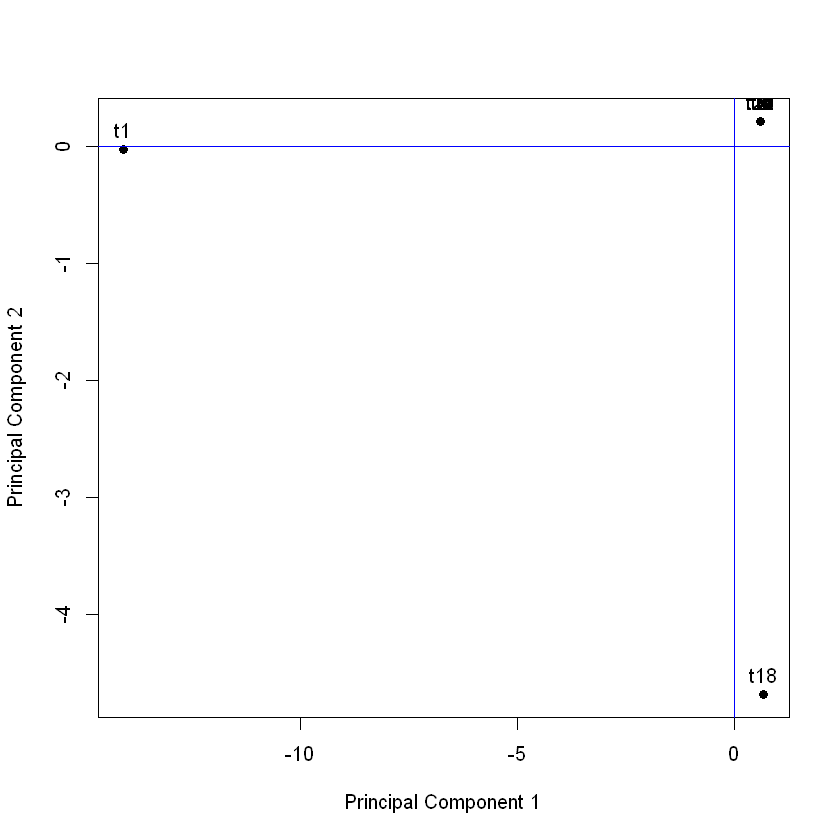

In [26]:
hour.names <- paste0('t',seq(1,24,1))
plot(x = pc1.space, y = pc2.space, pch = 19, xlab="Principal Component 1", ylab="Principal Component 2")
abline(h=0, col='blue')
abline(v=0, col='blue')
text(x = pc1.space, y = pc2.space, labels = hour.names, pos = 3)

In [22]:
AbTime

[1] 18

In [23]:
DTime

t18 
4.734624

In [24]:
CumProp.Time

[1] 0.9 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0

## 哪些日期`三芝站`距離原點最遠
根據前述，我們計算出的M.Space儲存387天中每一天距離(0,0)最遠的測站以及其距離。  
其中有10天，找出的站是三芝(第8站)。

In [11]:
round(M.Space[AbSt == 8, 2], 4) # Distance

[1] 6.5507 7.9456 2.2296 6.2291 3.2249 4.2770 2.7177 4.2895 7.2675 2.7177

In [12]:
summary(M.Space[AbSt == 8, 2])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.230   2.845   4.283   4.745   6.470   7.946 

下面是對應日期與距離的結果

In [13]:
Dates_st_8 <- substr(df353.meiyu$Time[which(AVBL.PCA==1)[which(AbSt == 8)]*24], 1,10)
cbind(Dates_st_8, round(M.Space[AbSt == 8, 2],4))

Dates_st_8,
2011/05/16,6.5507
2013/05/11,7.9456
2013/06/17,2.2296
2014/05/21,6.2291
2014/05/31,3.2249
2014/06/18,4.277
2016/05/30,2.7177
2017/05/14,4.2895
2017/06/02,7.2675
2018/05/07,2.7177


其中，在2017/06/02便為上一次舉例的日期，距離為7.2675。接著我們畫出上述所有日期的降雨量折線圖，異常的測站皆為三芝(第8站)。

In [14]:
M2 <- cbind(AbSt, AbTime)
M2[AbSt == 8, 2] # The abnormal hour

[1] 12  4  7 21  4 19  5  3 11  8

In [15]:
M.Time

18,4.734624
15,10.535258
12,10.164126
1,14.846436
24,11.522008
1,8.022205
4,7.349649
11,6.516044
20,5.050554
23,6.259213
1,12.427554


In [21]:
M3 <- M2[AbSt == 8, ] # The abnormal station
M4 <- cbind(Dates_st_8, M3, round(M.Space[AbSt == 8, 2],4))
colnames(M4) <- c('Date','AbSt','AbTime','DSt')
M4

Date,AbSt,AbTime,DSt
2011/05/16,8,12,6.5507
2013/05/11,8,4,7.9456
2013/06/17,8,7,2.2296
2014/05/21,8,21,6.2291
2014/05/31,8,4,3.2249
2014/06/18,8,19,4.277
2016/05/30,8,5,2.7177
2017/05/14,8,3,4.2895
2017/06/02,8,11,7.2675
2018/05/07,8,8,2.7177


### 2011/05/16
距離約為6.5507

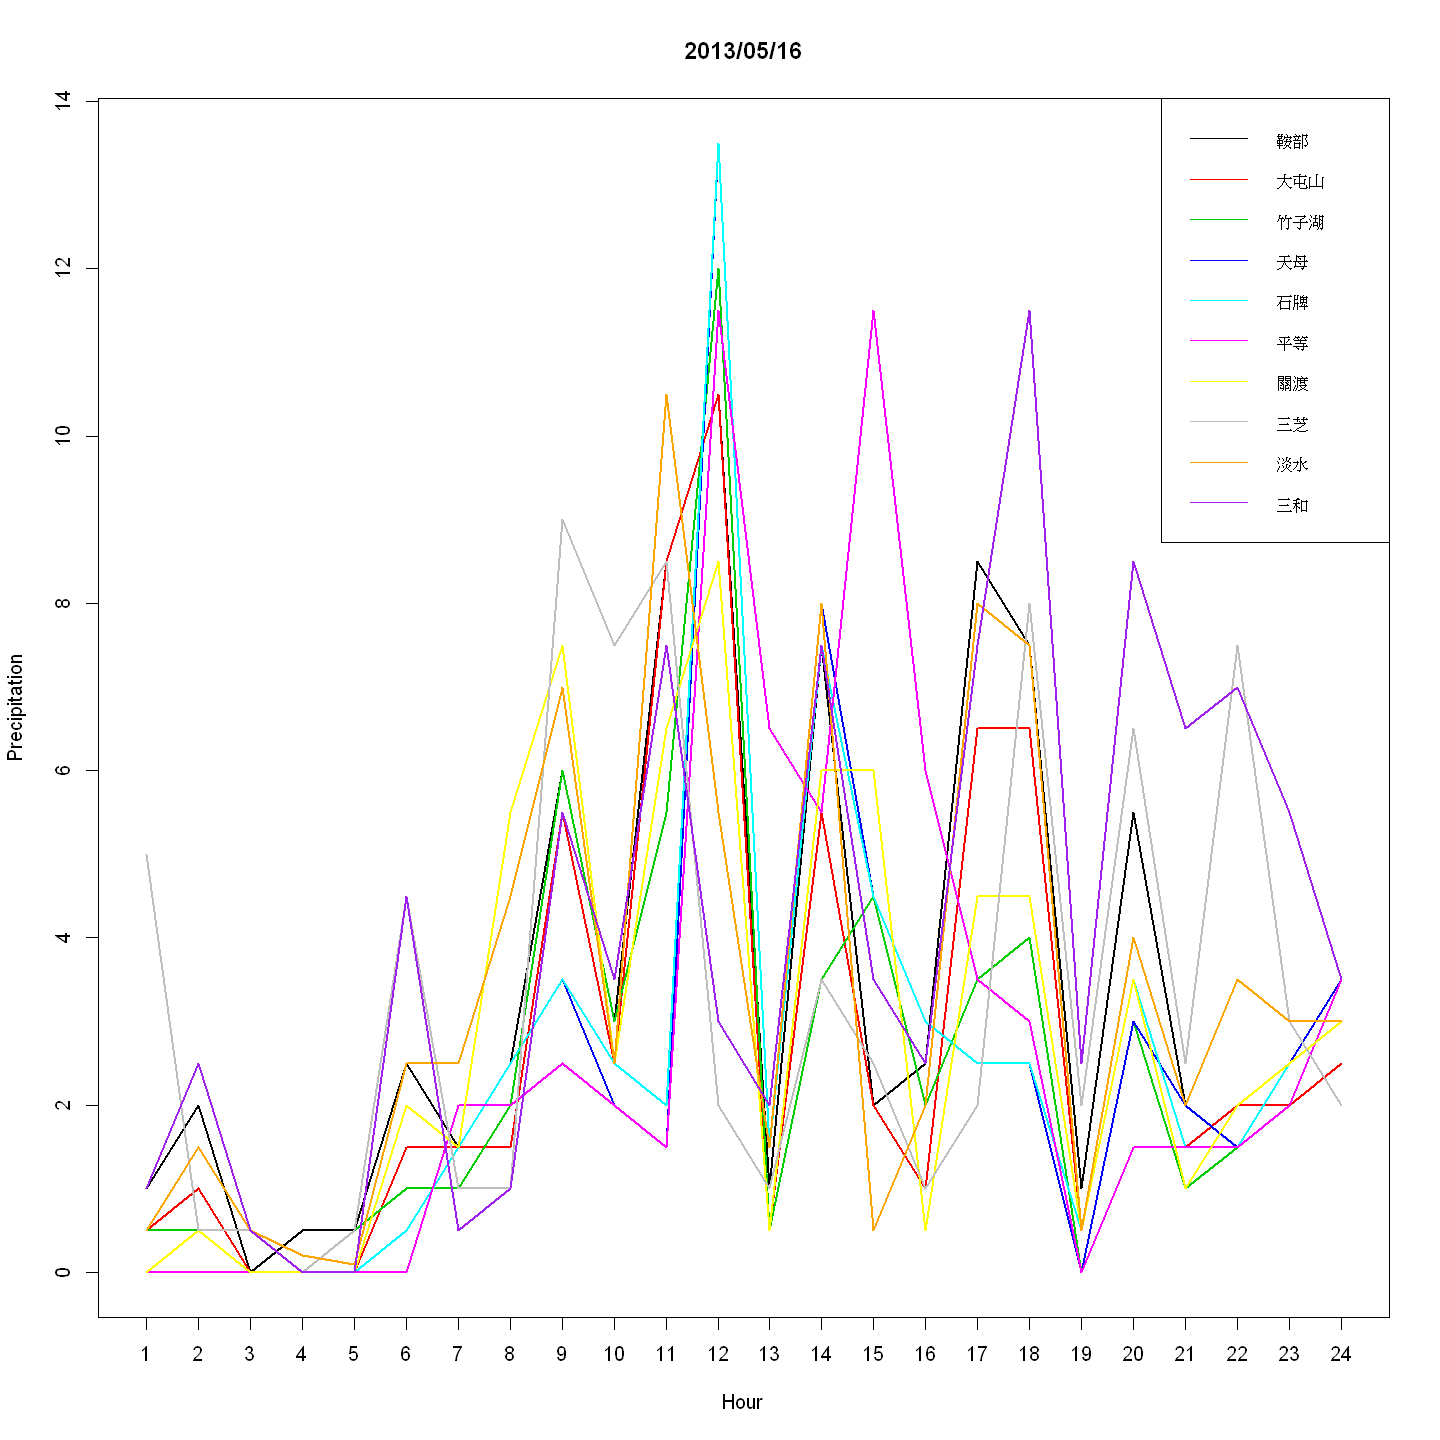

In [22]:
options(repr.plot.width=12, repr.plot.height=12)

d0.ind <- which(df353.meiyu$Time %in% '2011/05/16 01')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, Nearest.ind]
df.space <- df

st.name <- as.character(station353[station353$StationID == st.chosen.id,2])  
st.name9 <- d.min.st_name[, which(st.chosen.id == colnames(d.min.st_name))]
st.names <- c(st.name, st.name9)

# Overplotted
plot.zoo(df.space, 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = '2013/05/16',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:24, labels = seq(1,24,1))
legend('topright', legend=st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.8)

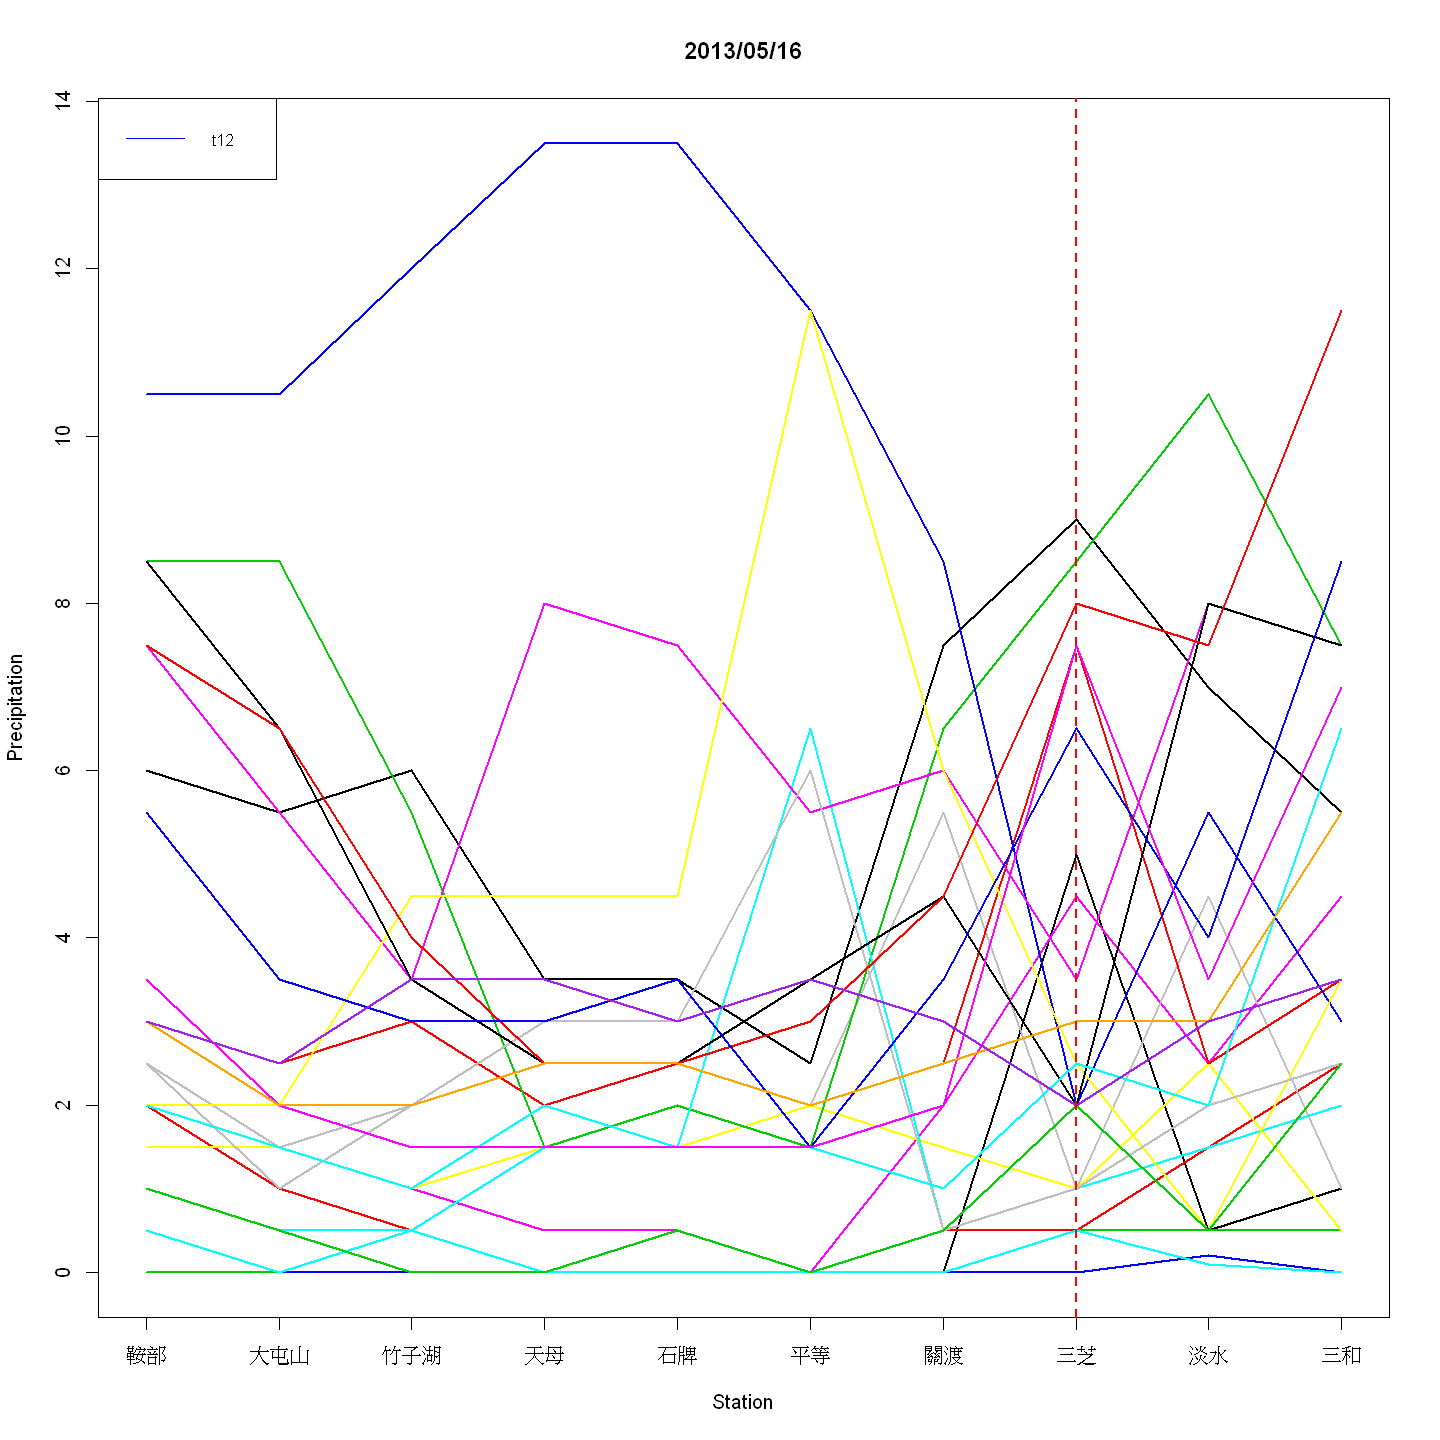

In [30]:
df.time <- t(df)
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = '2013/05/16',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('topleft', legend=c('t12'), lty=1, col=12, cex=0.8)

## 2013/05/11
距離約為7.9456

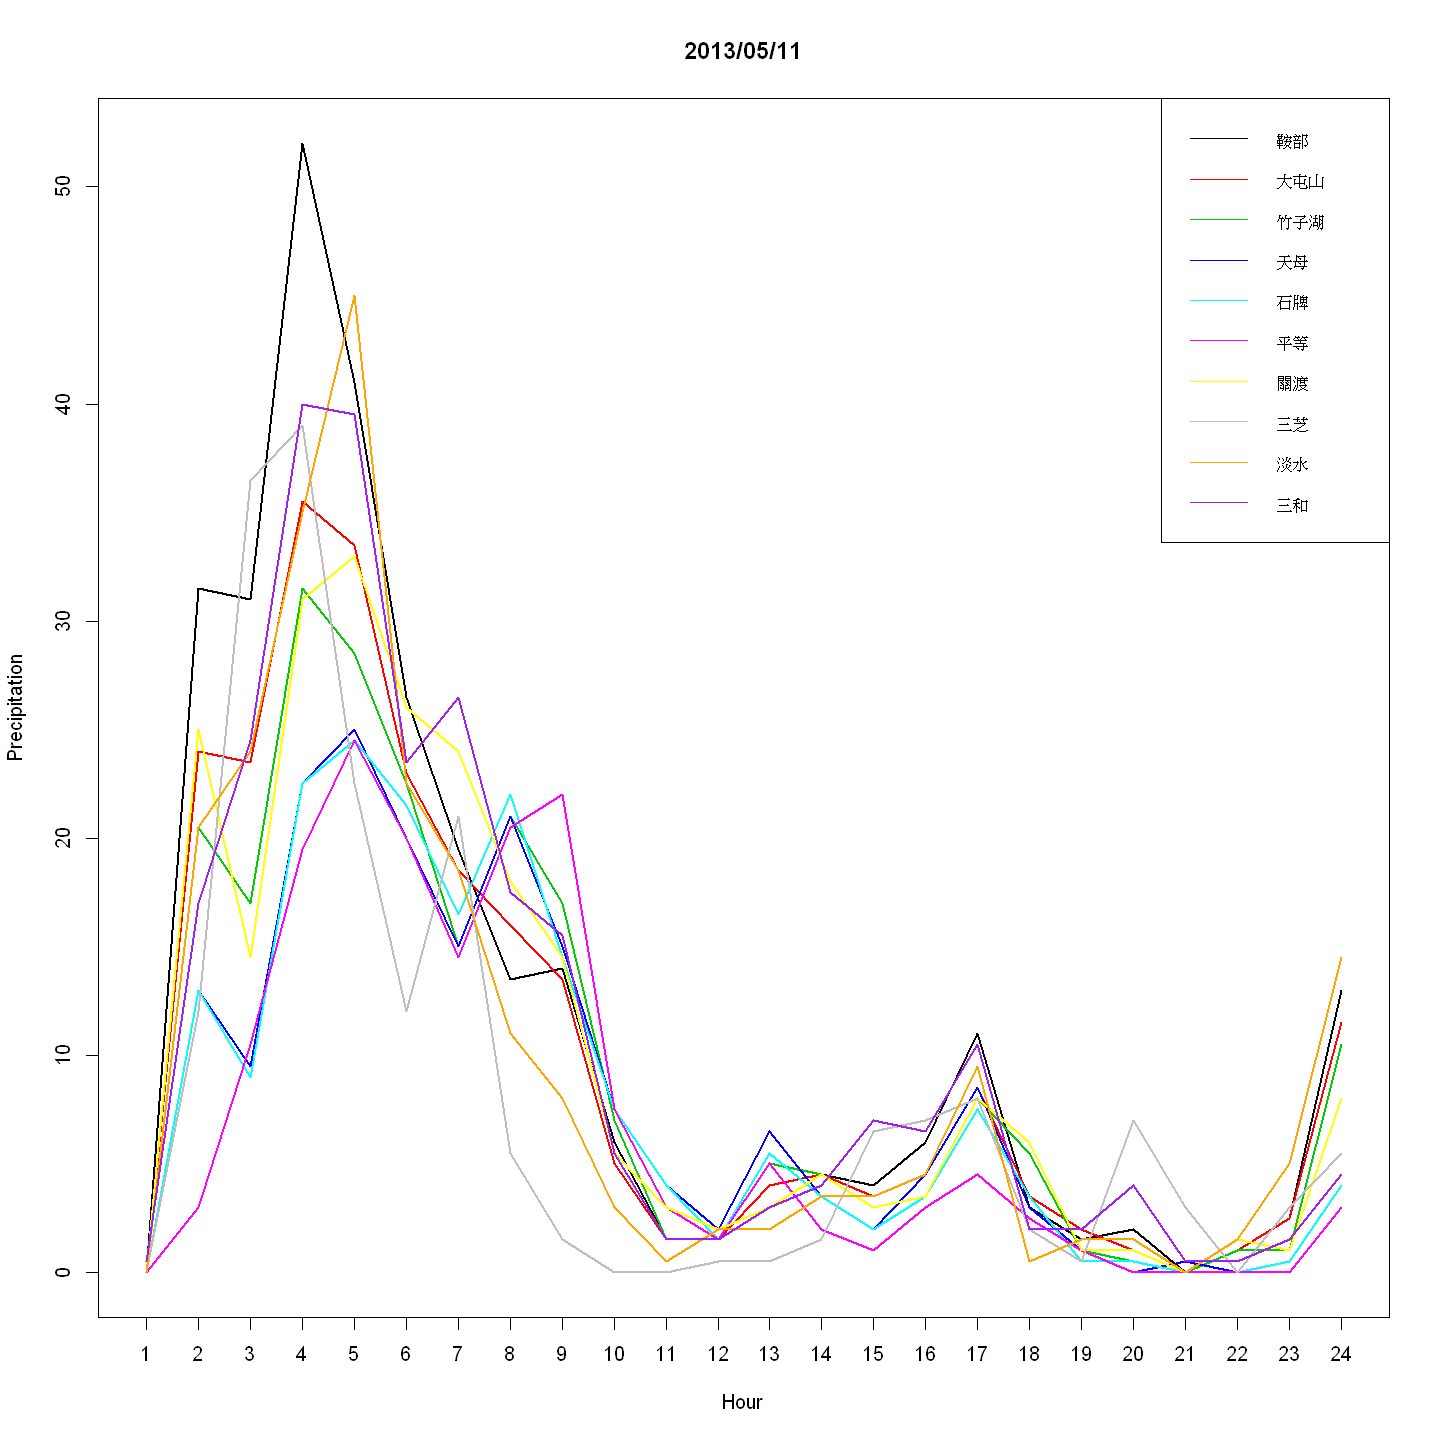

In [31]:
d0.ind <- which(df353.meiyu$Time %in% '2013/05/11 01')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, Nearest.ind]
df.space <- df

# Overplotted
plot.zoo(df.space, 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = '2013/05/11',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:24, labels = seq(1,24,1))
legend('topright', legend=st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.8)

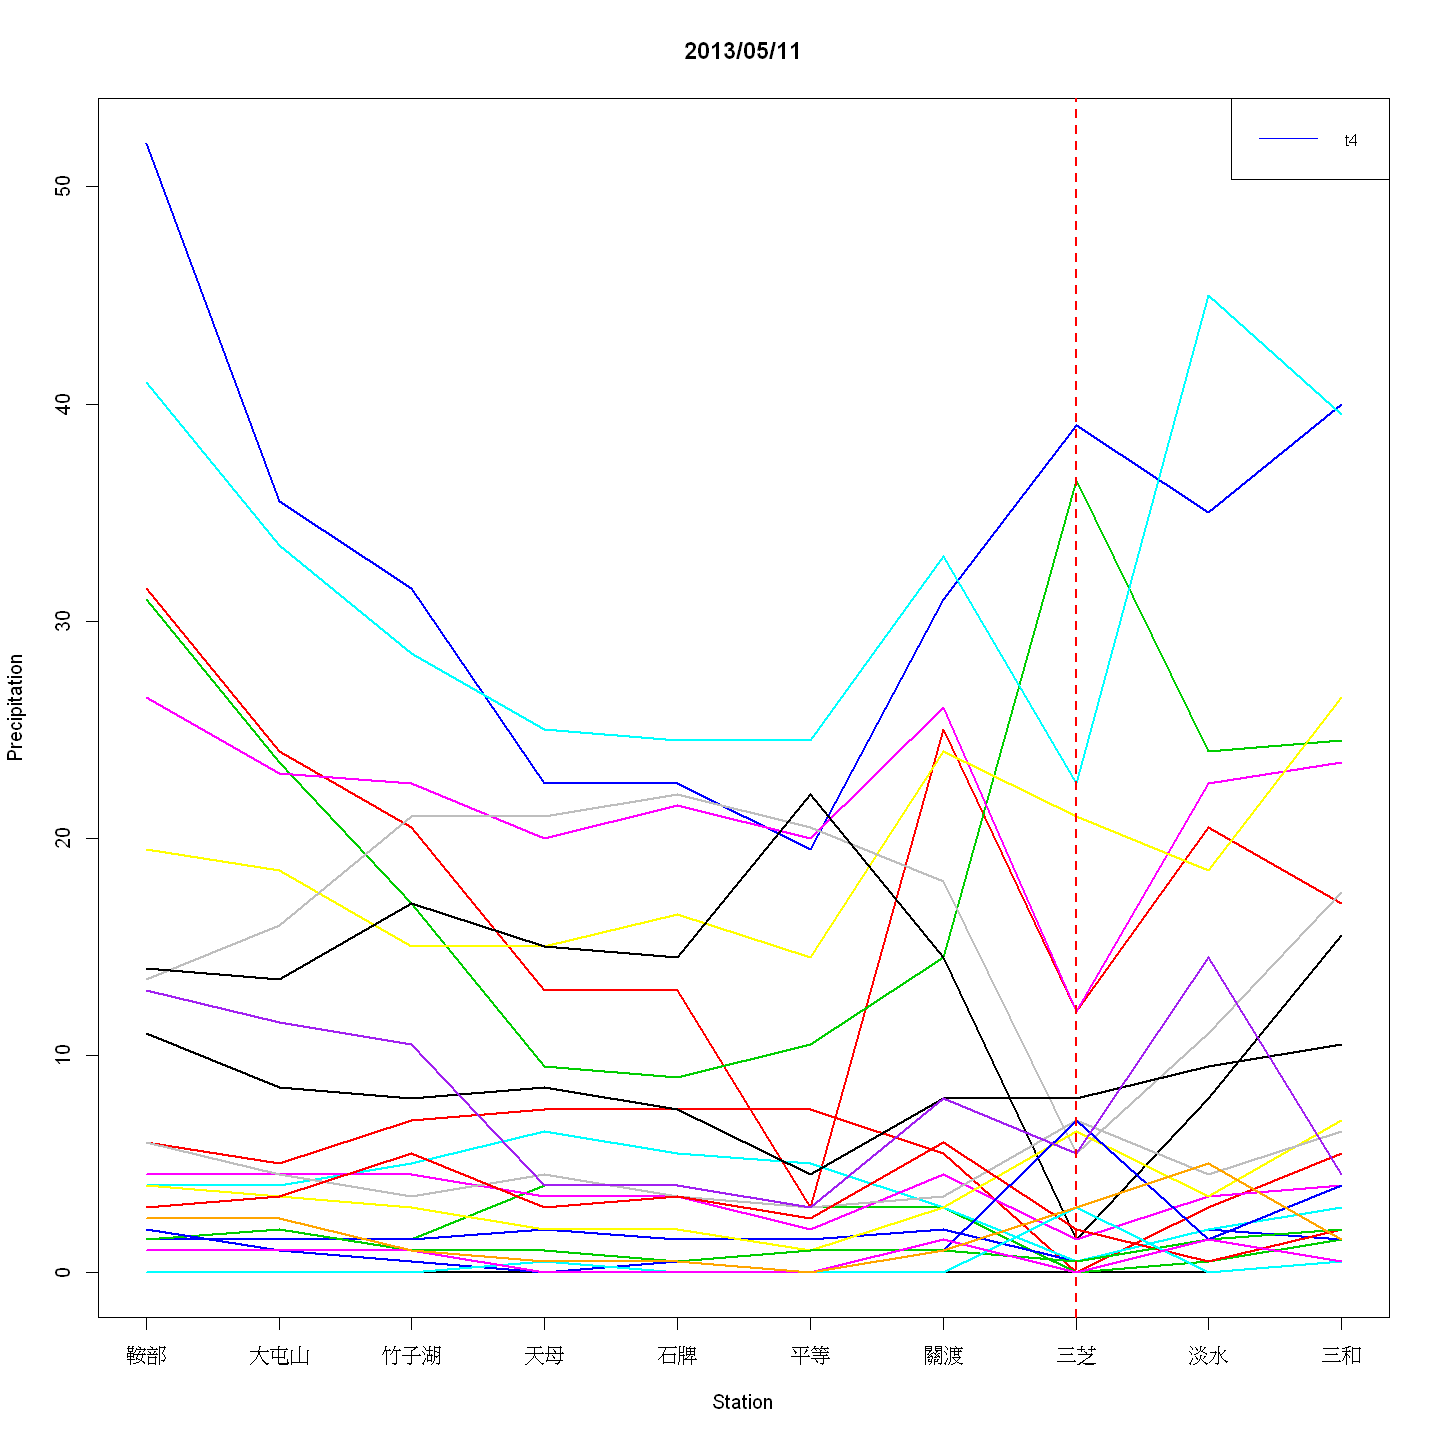

In [32]:
df.time <- t(df)
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = '2013/05/11',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('topright', legend=c('t4'), lty=1, col=4, cex=0.8)

## 2013/06/17
距離約為2.2296

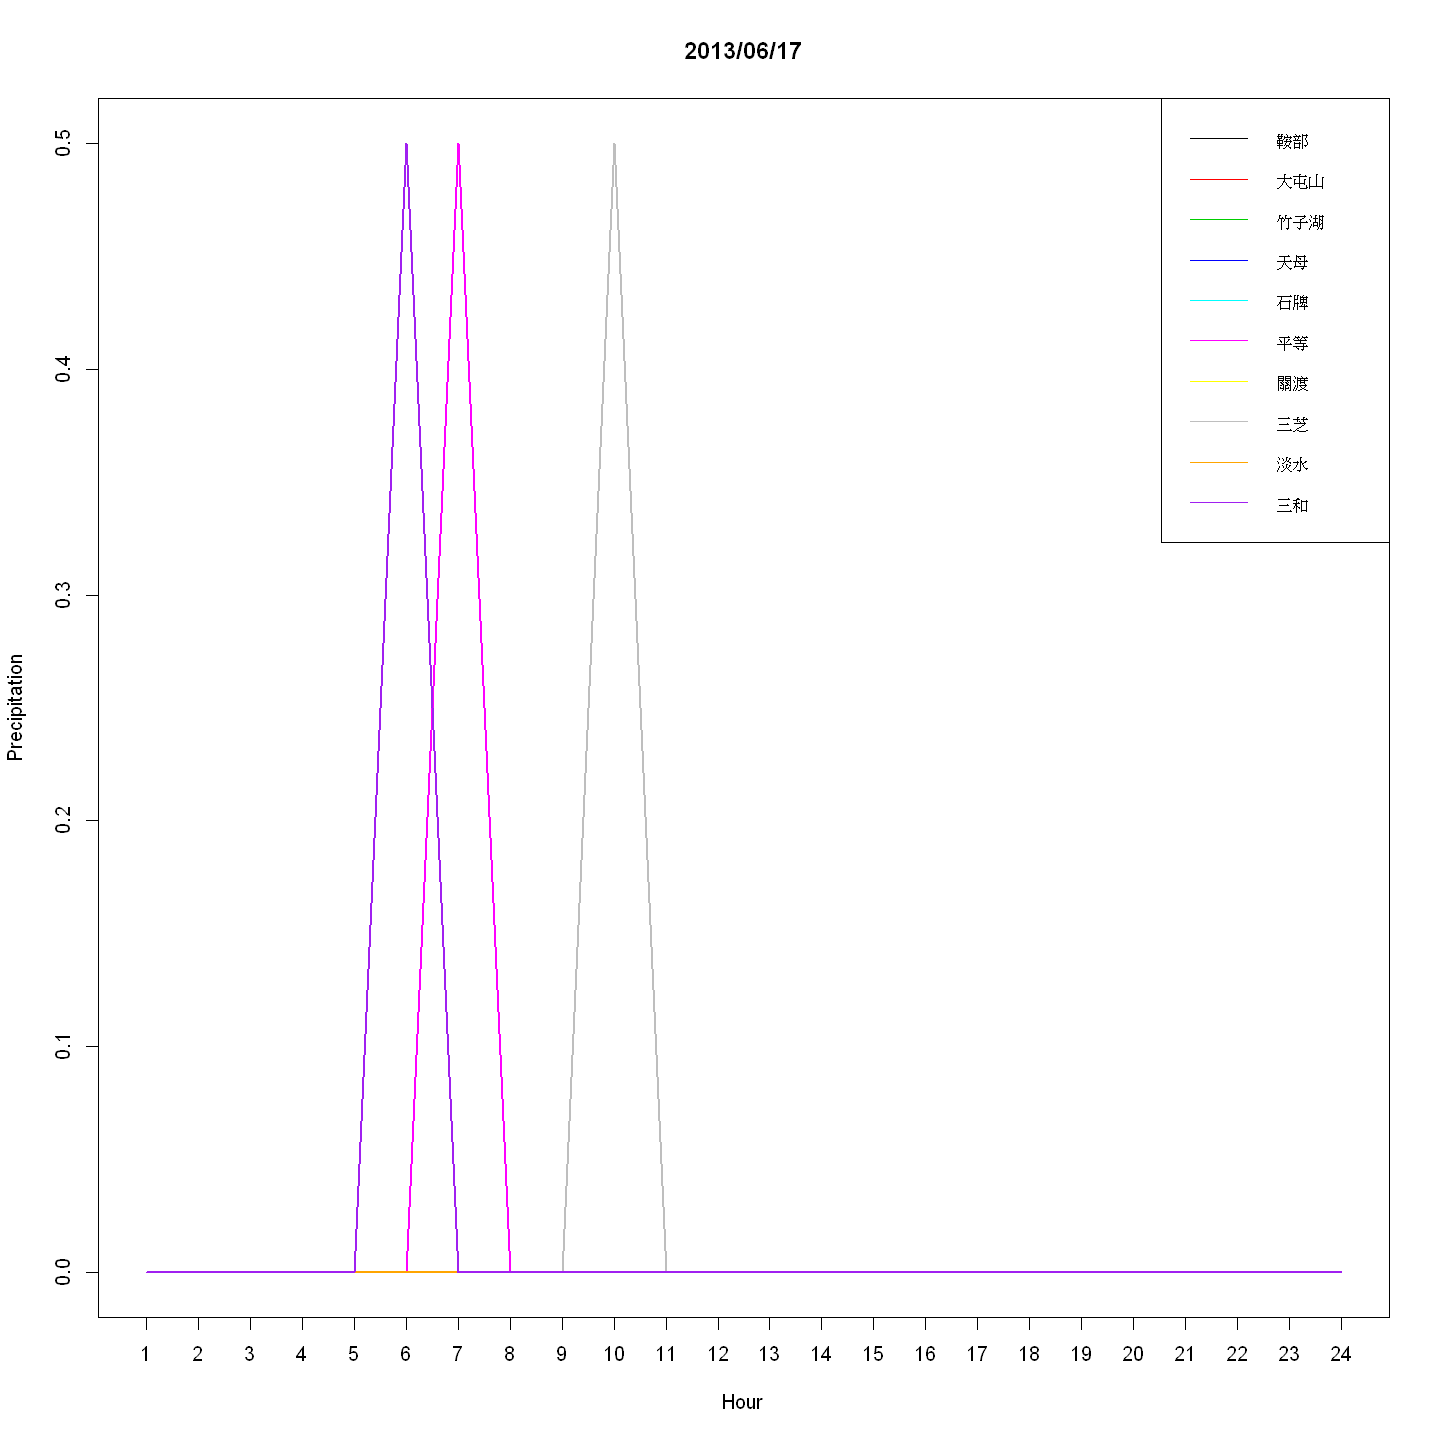

In [37]:
d0.ind <- which(df353.meiyu$Time %in% '2013/06/17 01')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, Nearest.ind]
df.space <- df

# Overplotted
plot.zoo(df.space, 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = '2013/06/17',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:24, labels = seq(1,24,1))
legend('topright', legend=st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.8)

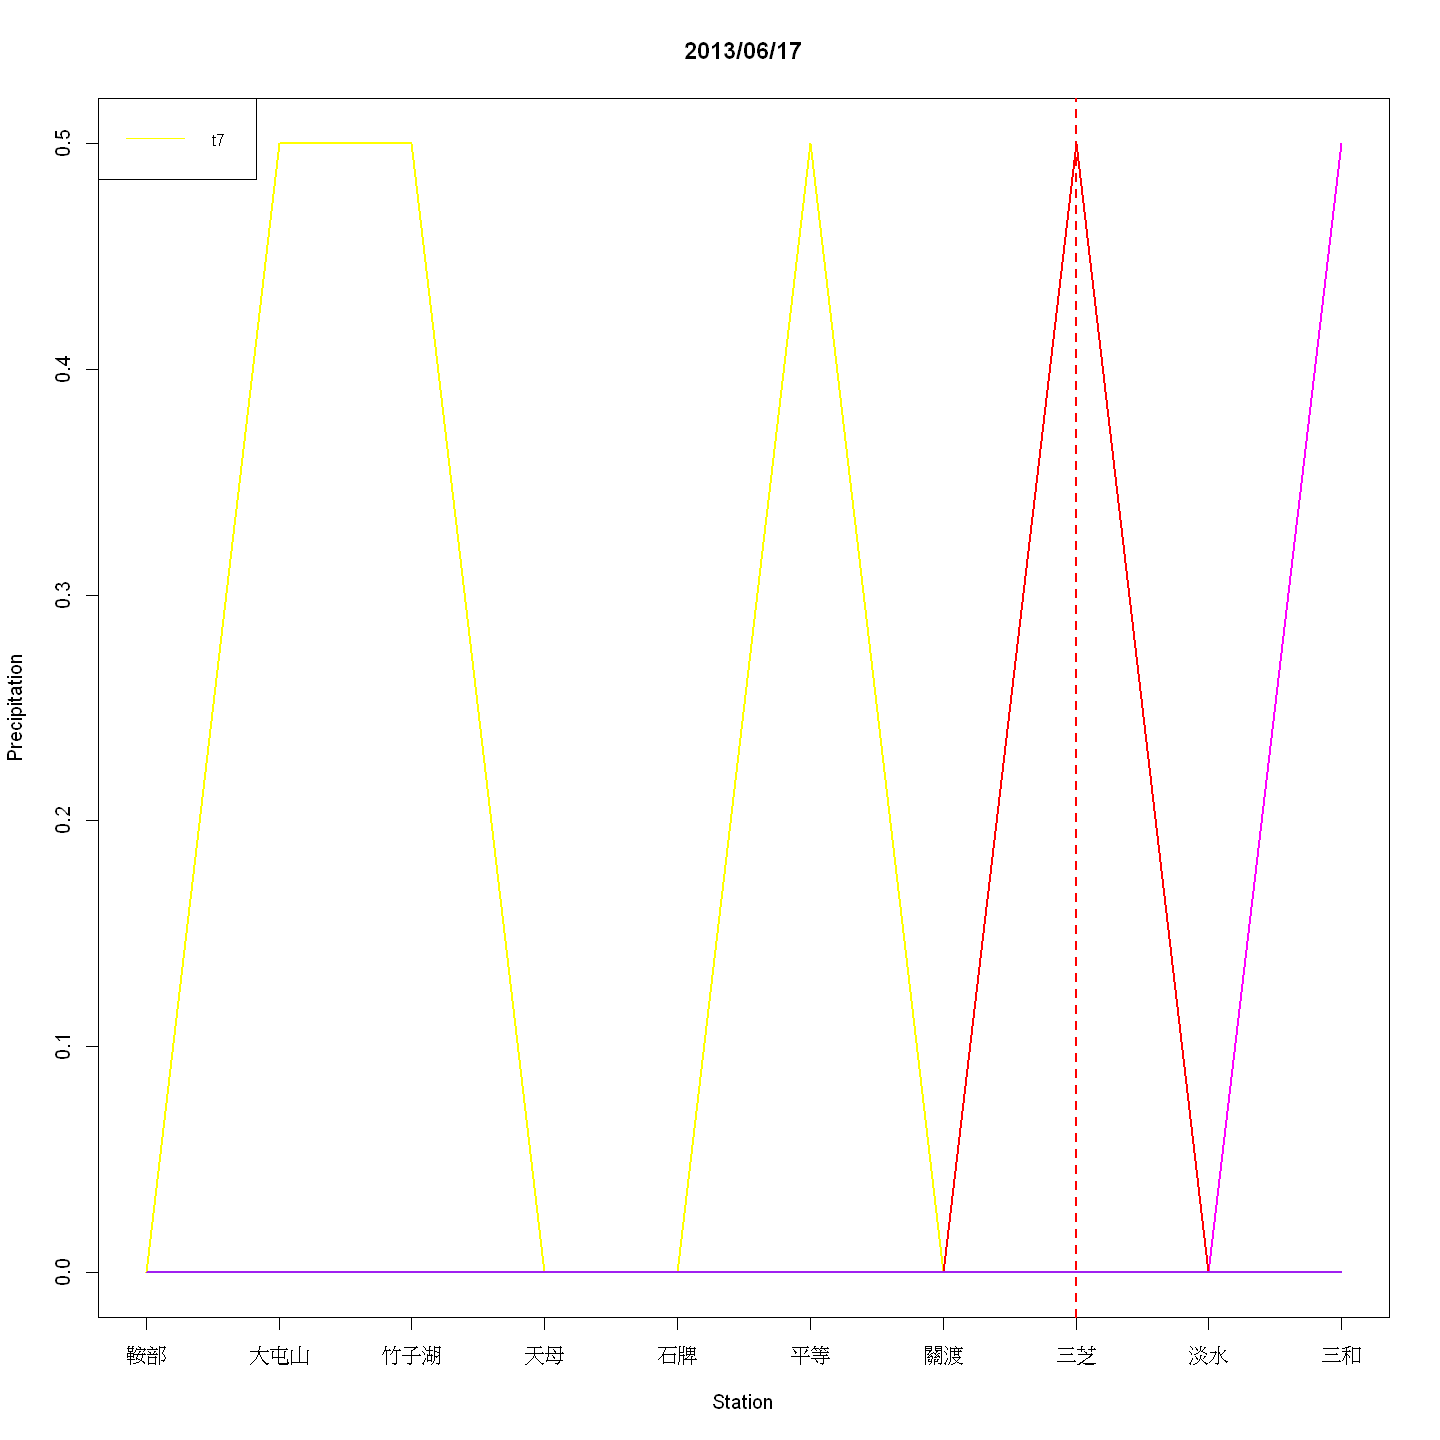

In [38]:
df.time <- t(df)
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = '2013/06/17',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('topleft', legend=c('t7'), lty=1, col=7, cex=0.8)

## 2014/05/21
距離約為6.2291

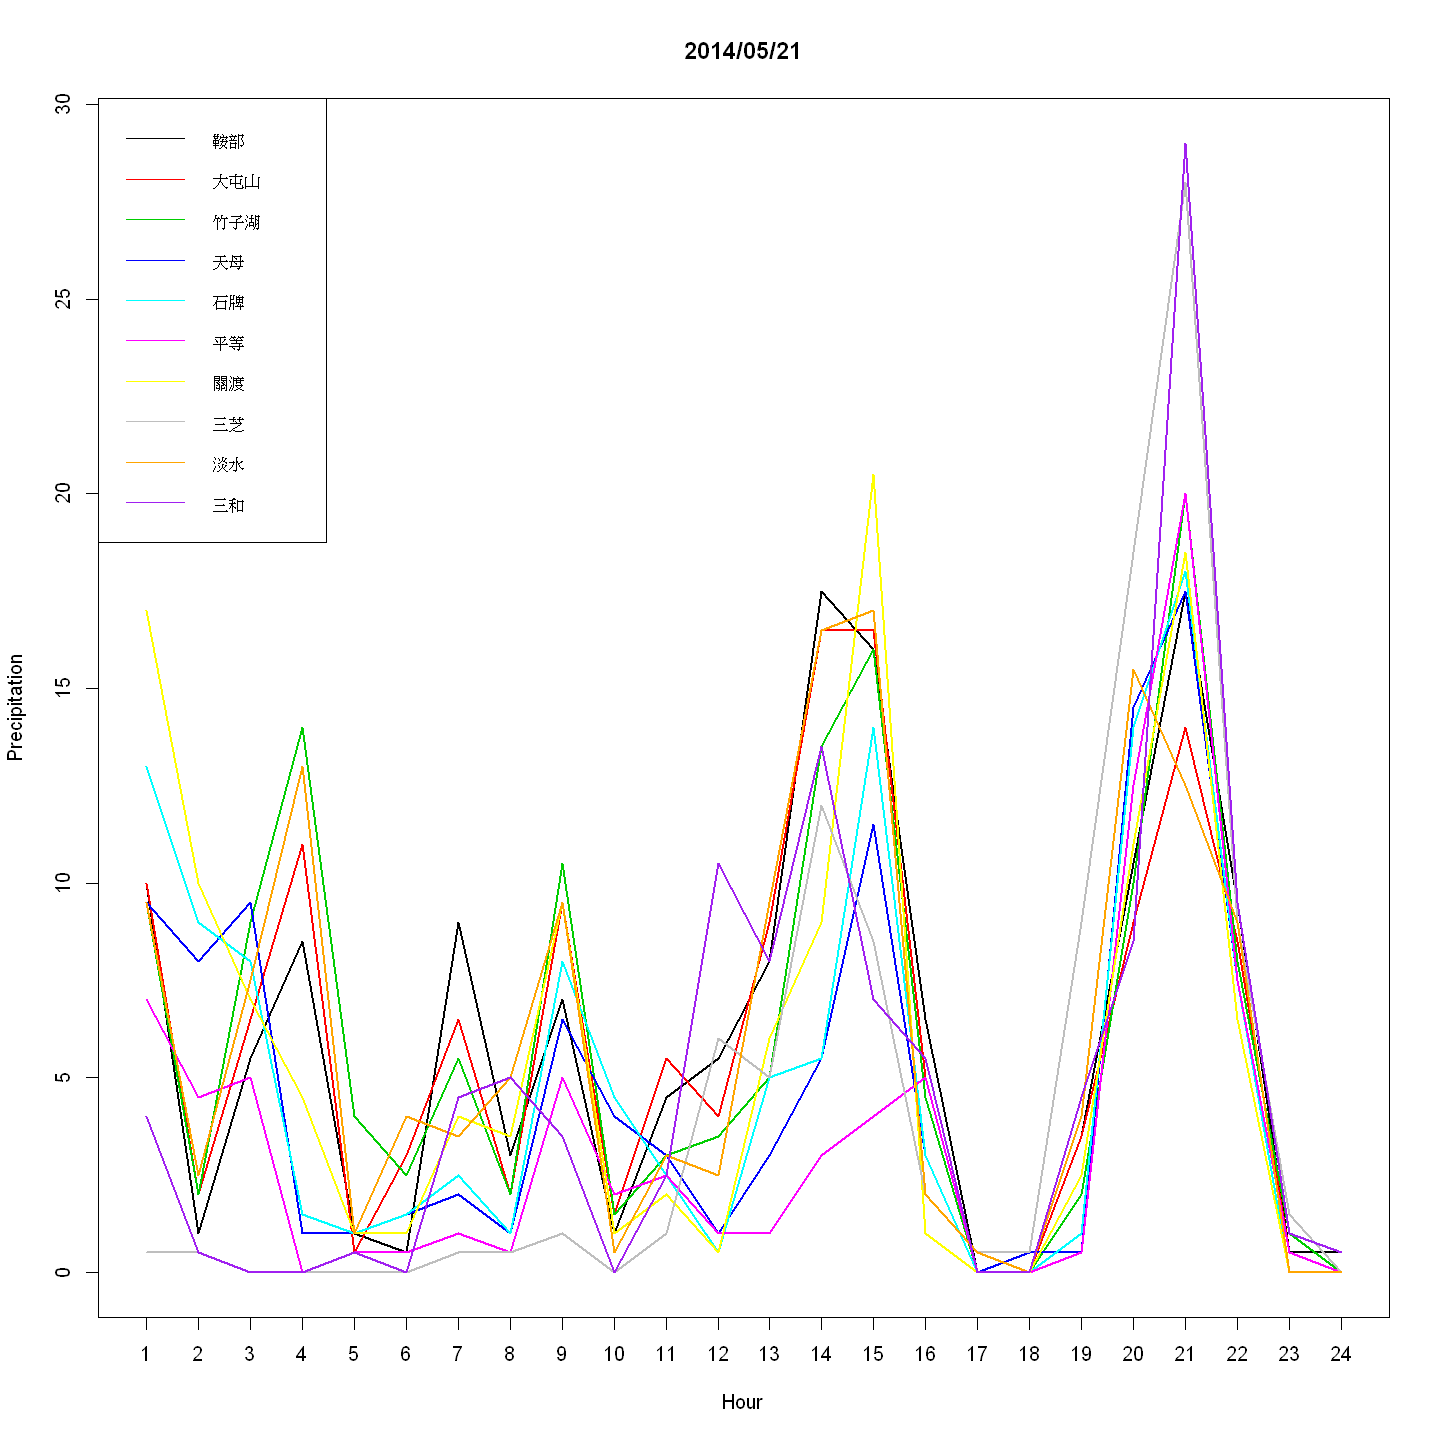

In [39]:
d0.ind <- which(df353.meiyu$Time %in% '2014/05/21 01')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, Nearest.ind]
df.space <- df

# Overplotted
plot.zoo(df.space, 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = '2014/05/21',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:24, labels = seq(1,24,1))
legend('topleft', legend=st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.8)

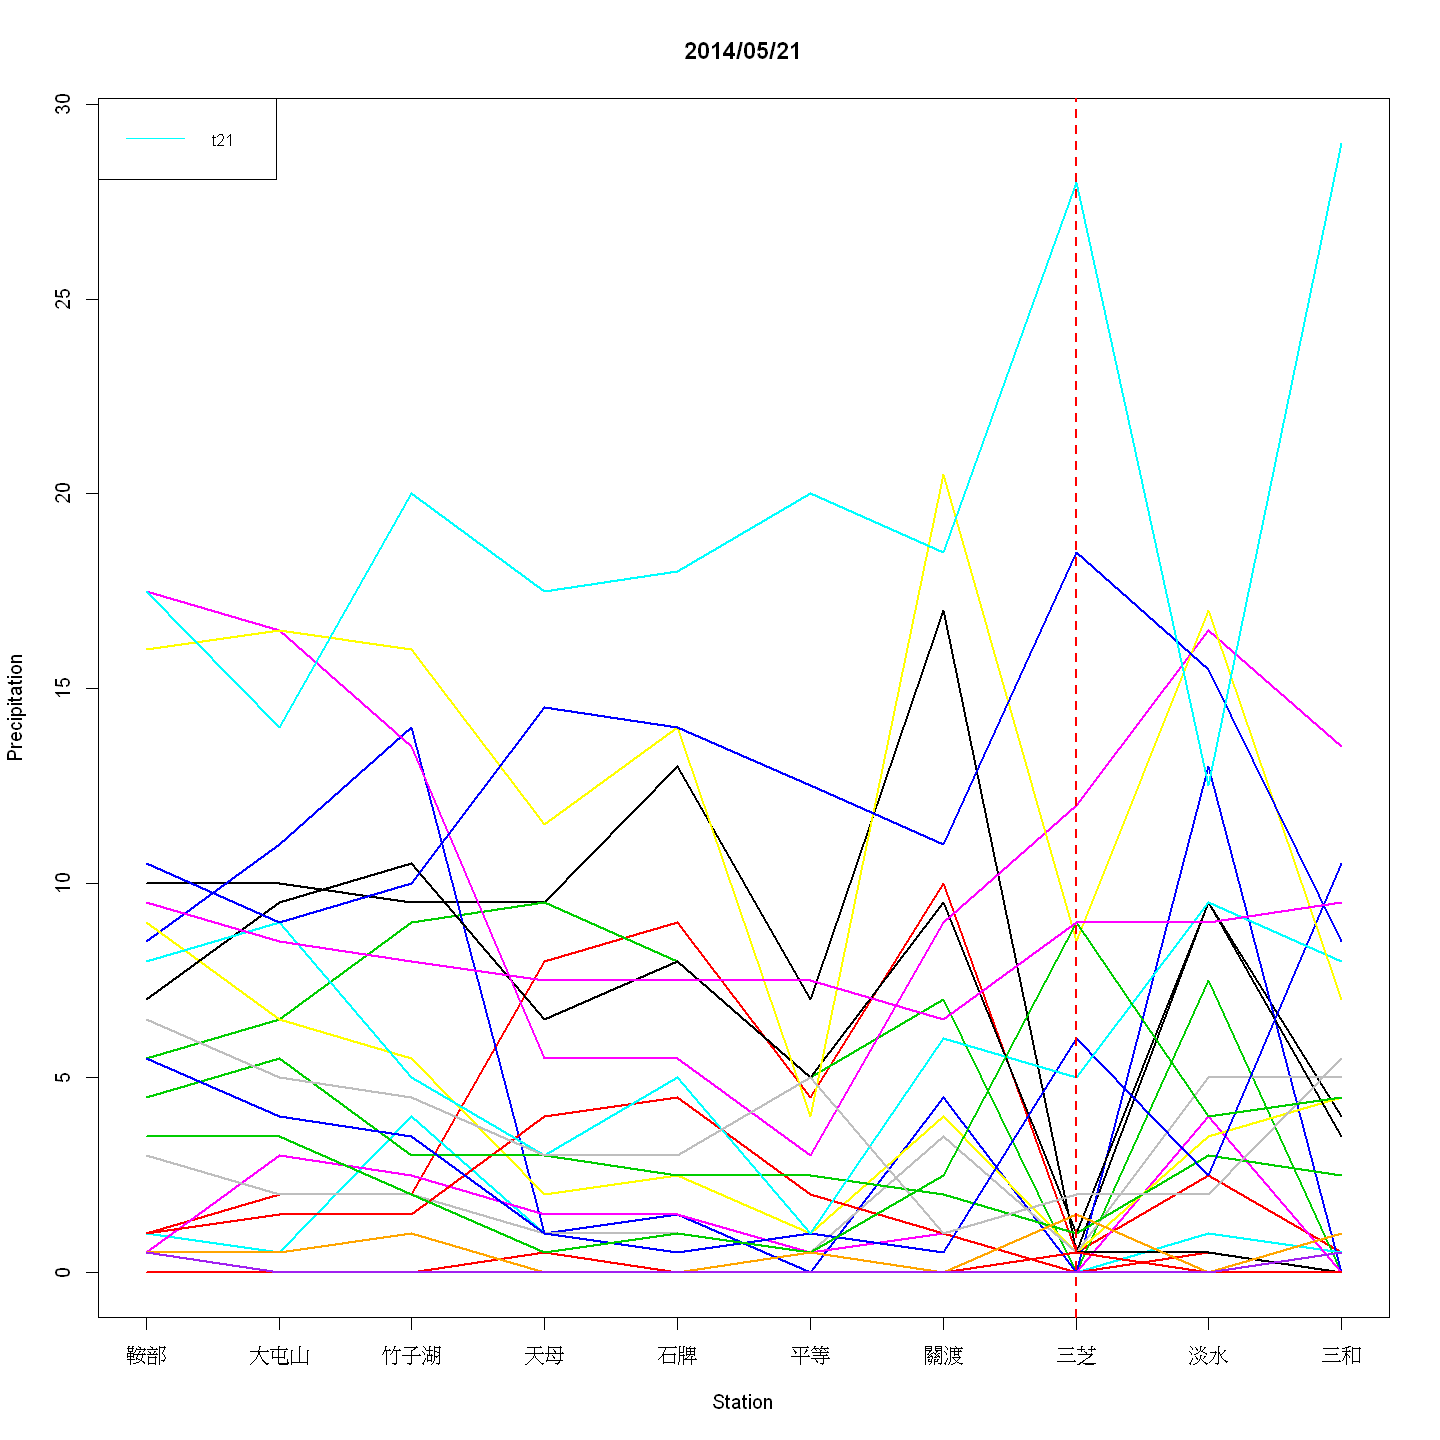

In [40]:
df.time <- t(df)
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = '2014/05/21',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('topleft', legend=c('t21'), lty=1, col=21, cex=0.8)

## 2014/05/31
距離約為3.2249

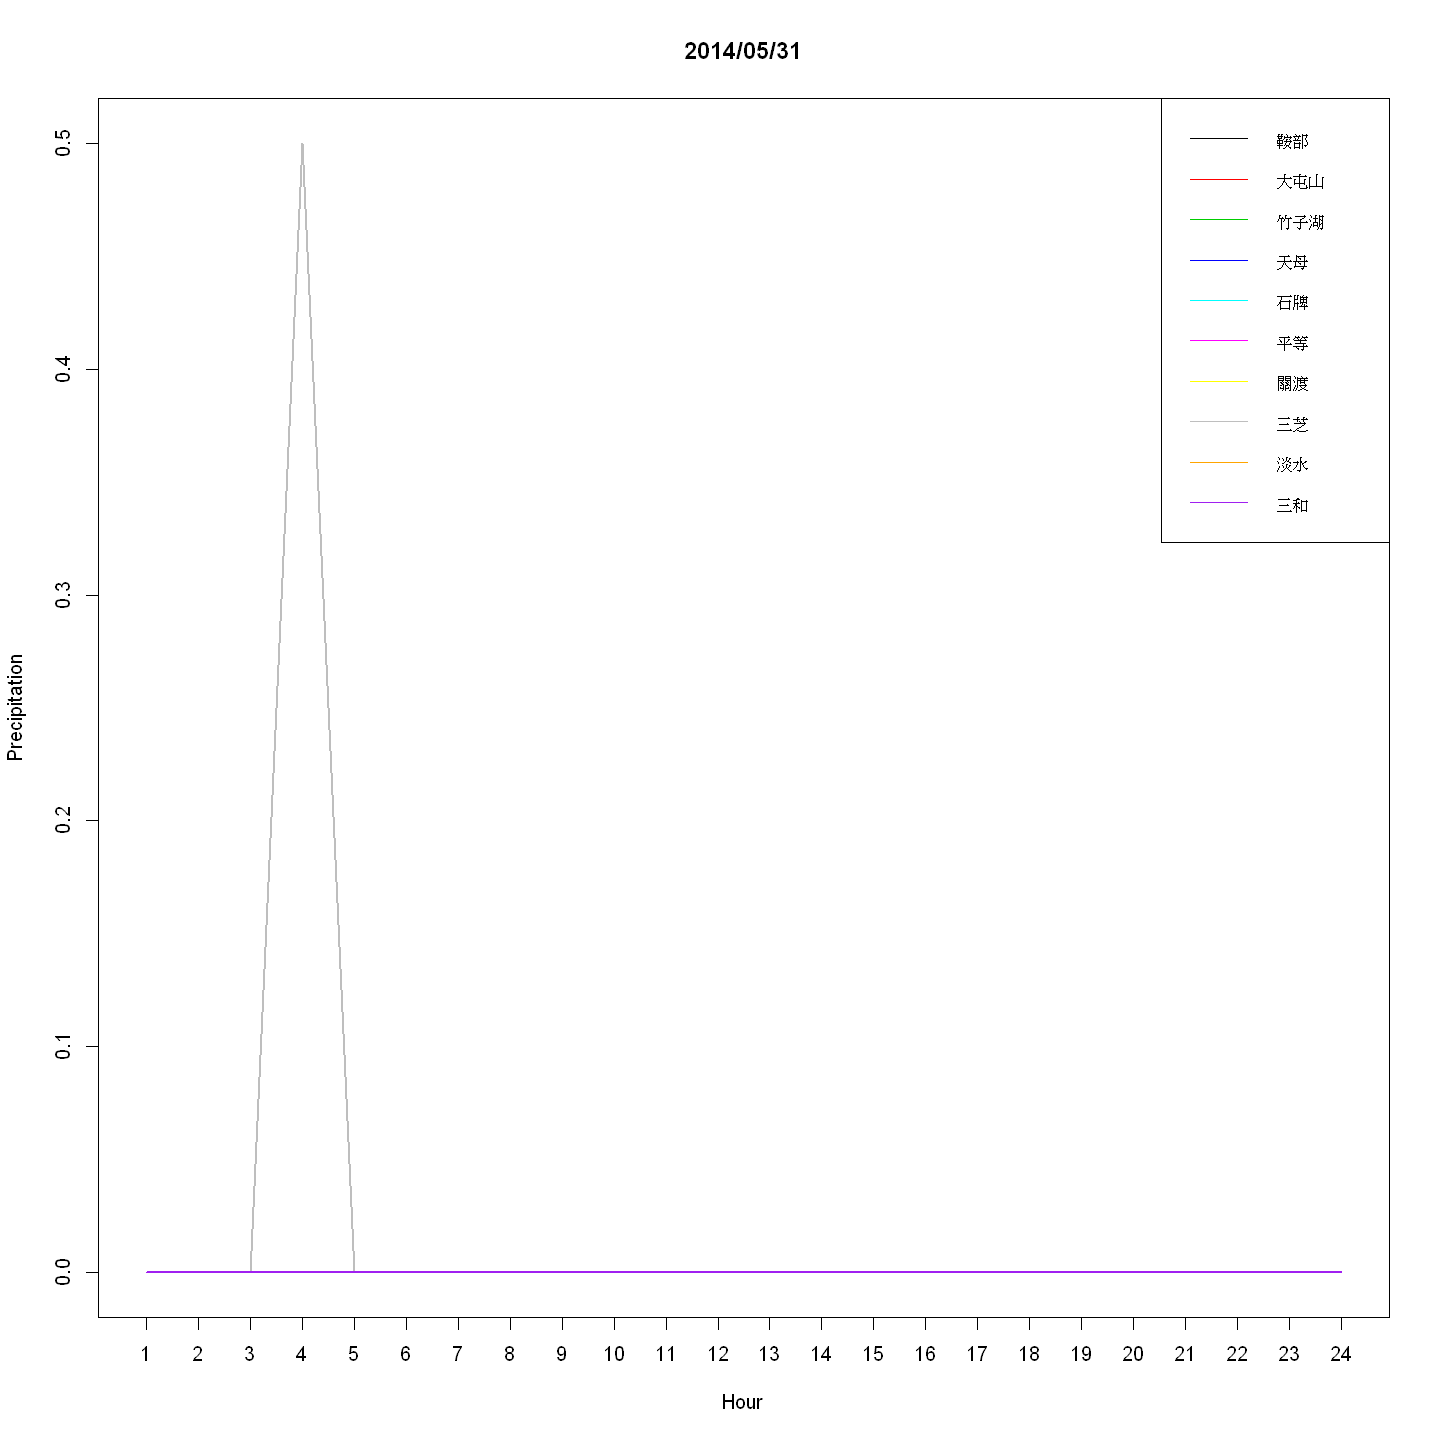

In [41]:
d0.ind <- which(df353.meiyu$Time %in% '2014/05/31 01')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, Nearest.ind]
df.space <- df

# Overplotted
plot.zoo(df.space, 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = '2014/05/31',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:24, labels = seq(1,24,1))
legend('topright', legend=st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.8)

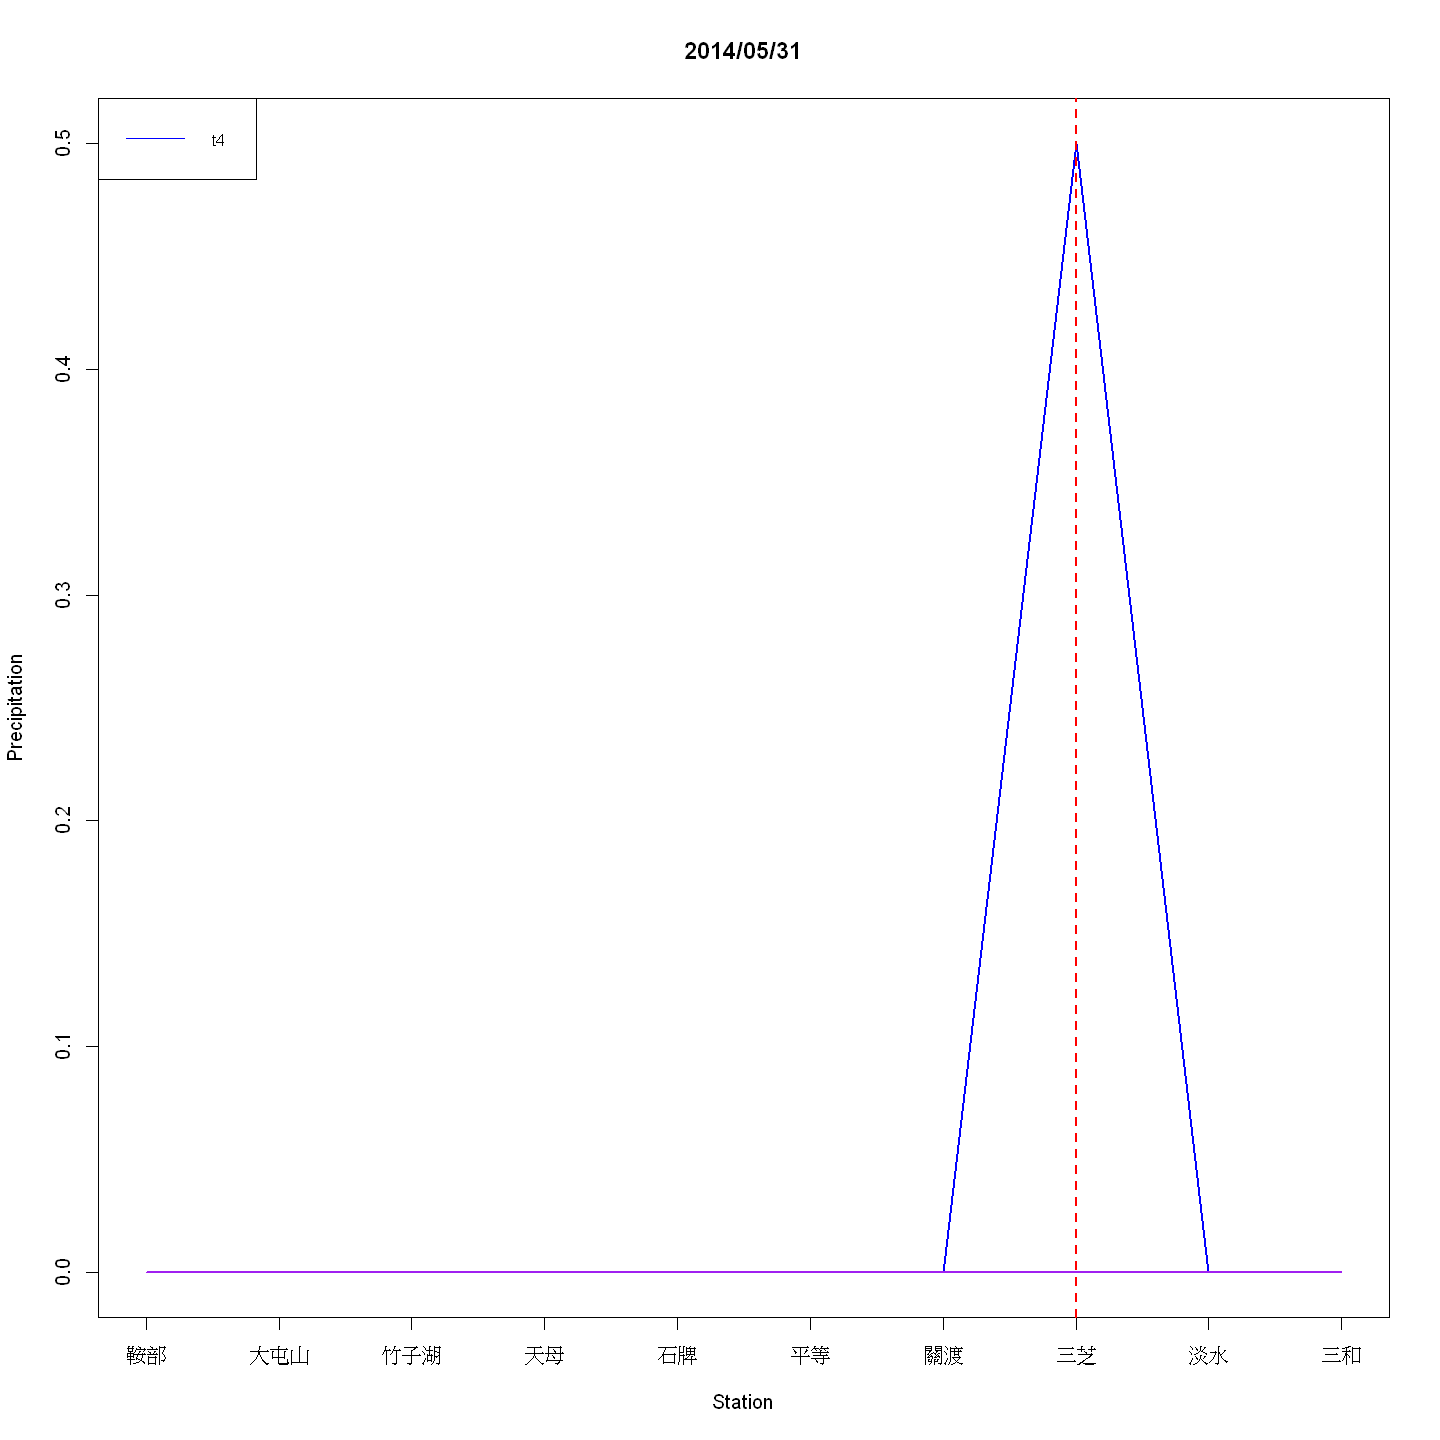

In [42]:
df.time <- t(df)
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = '2014/05/31',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('topleft', legend=c('t4'), lty=1, col=4, cex=0.8)

## 2014/06/18
距離約為4.277

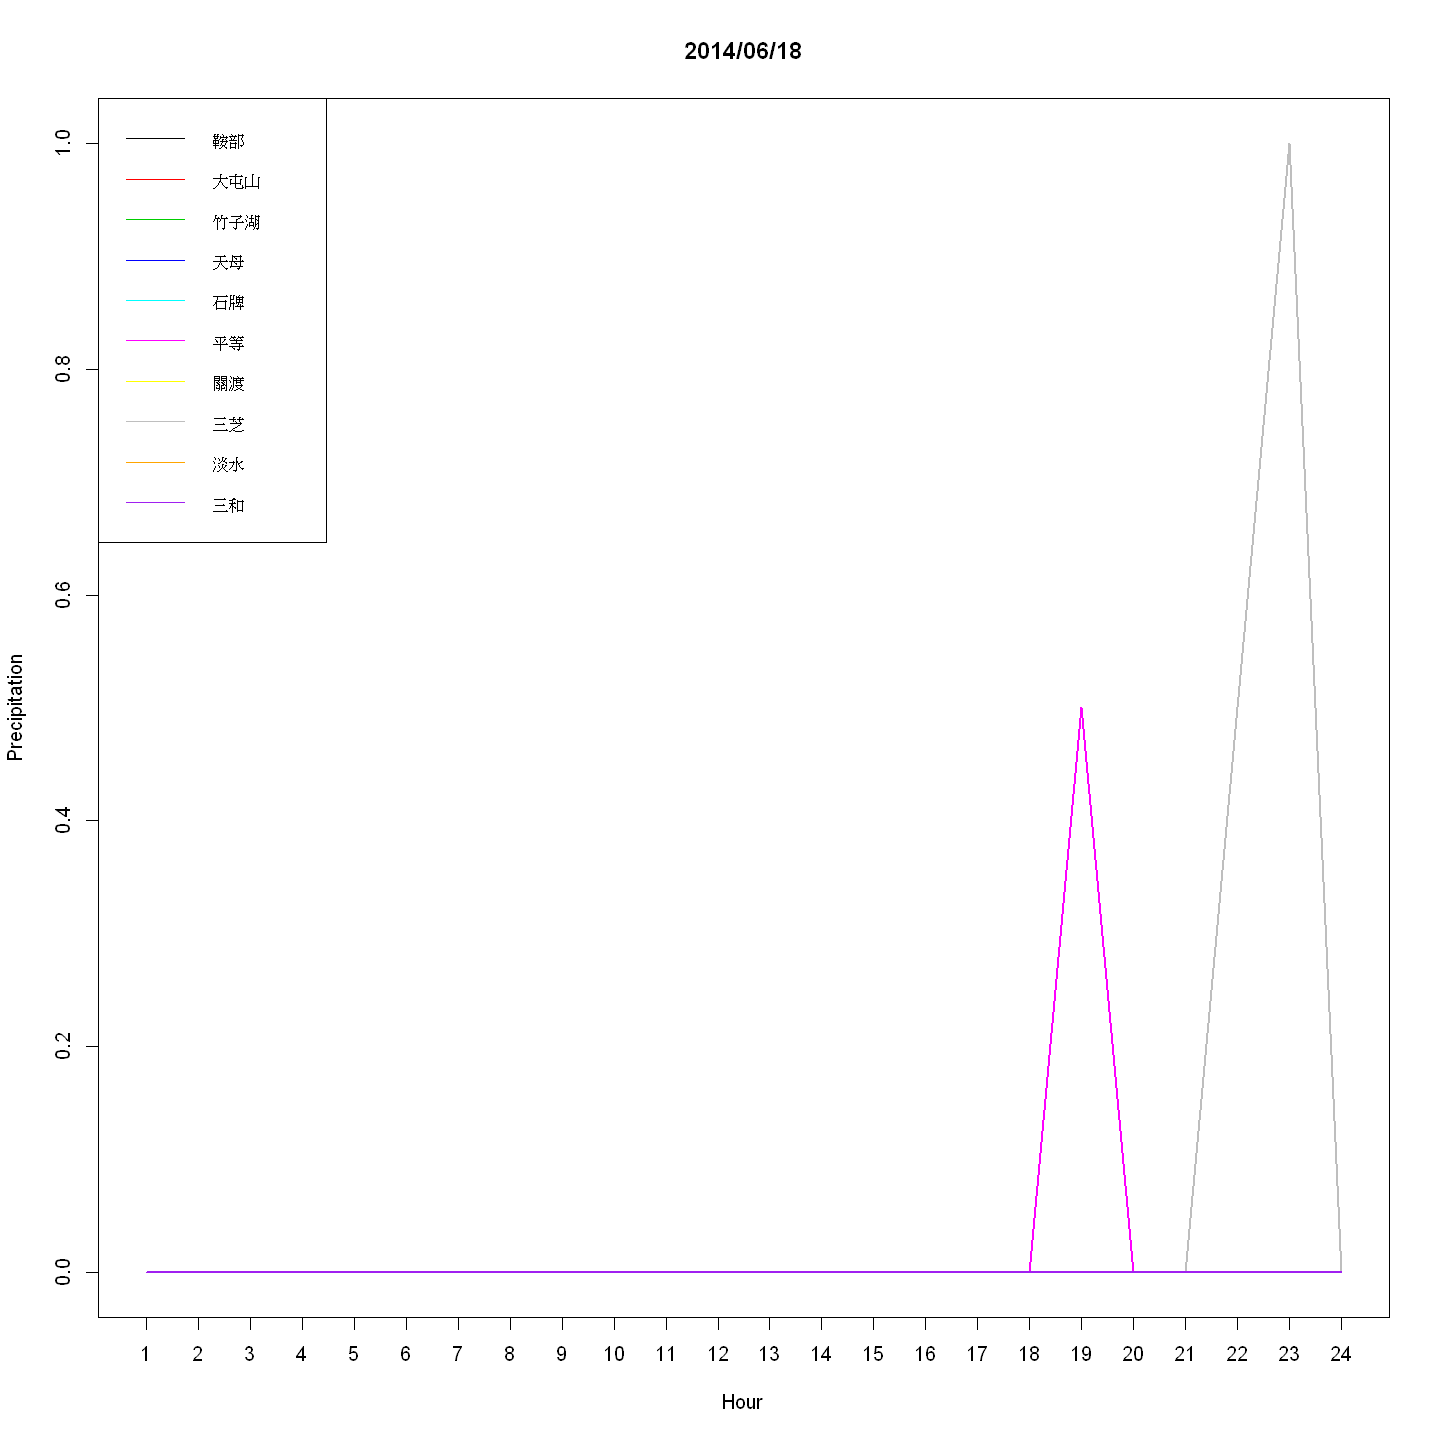

In [43]:
d0.ind <- which(df353.meiyu$Time %in% '2014/06/18 01')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, Nearest.ind]
df.space <- df

# Overplotted
plot.zoo(df.space, 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = '2014/06/18',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:24, labels = seq(1,24,1))
legend('topleft', legend=st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.8)

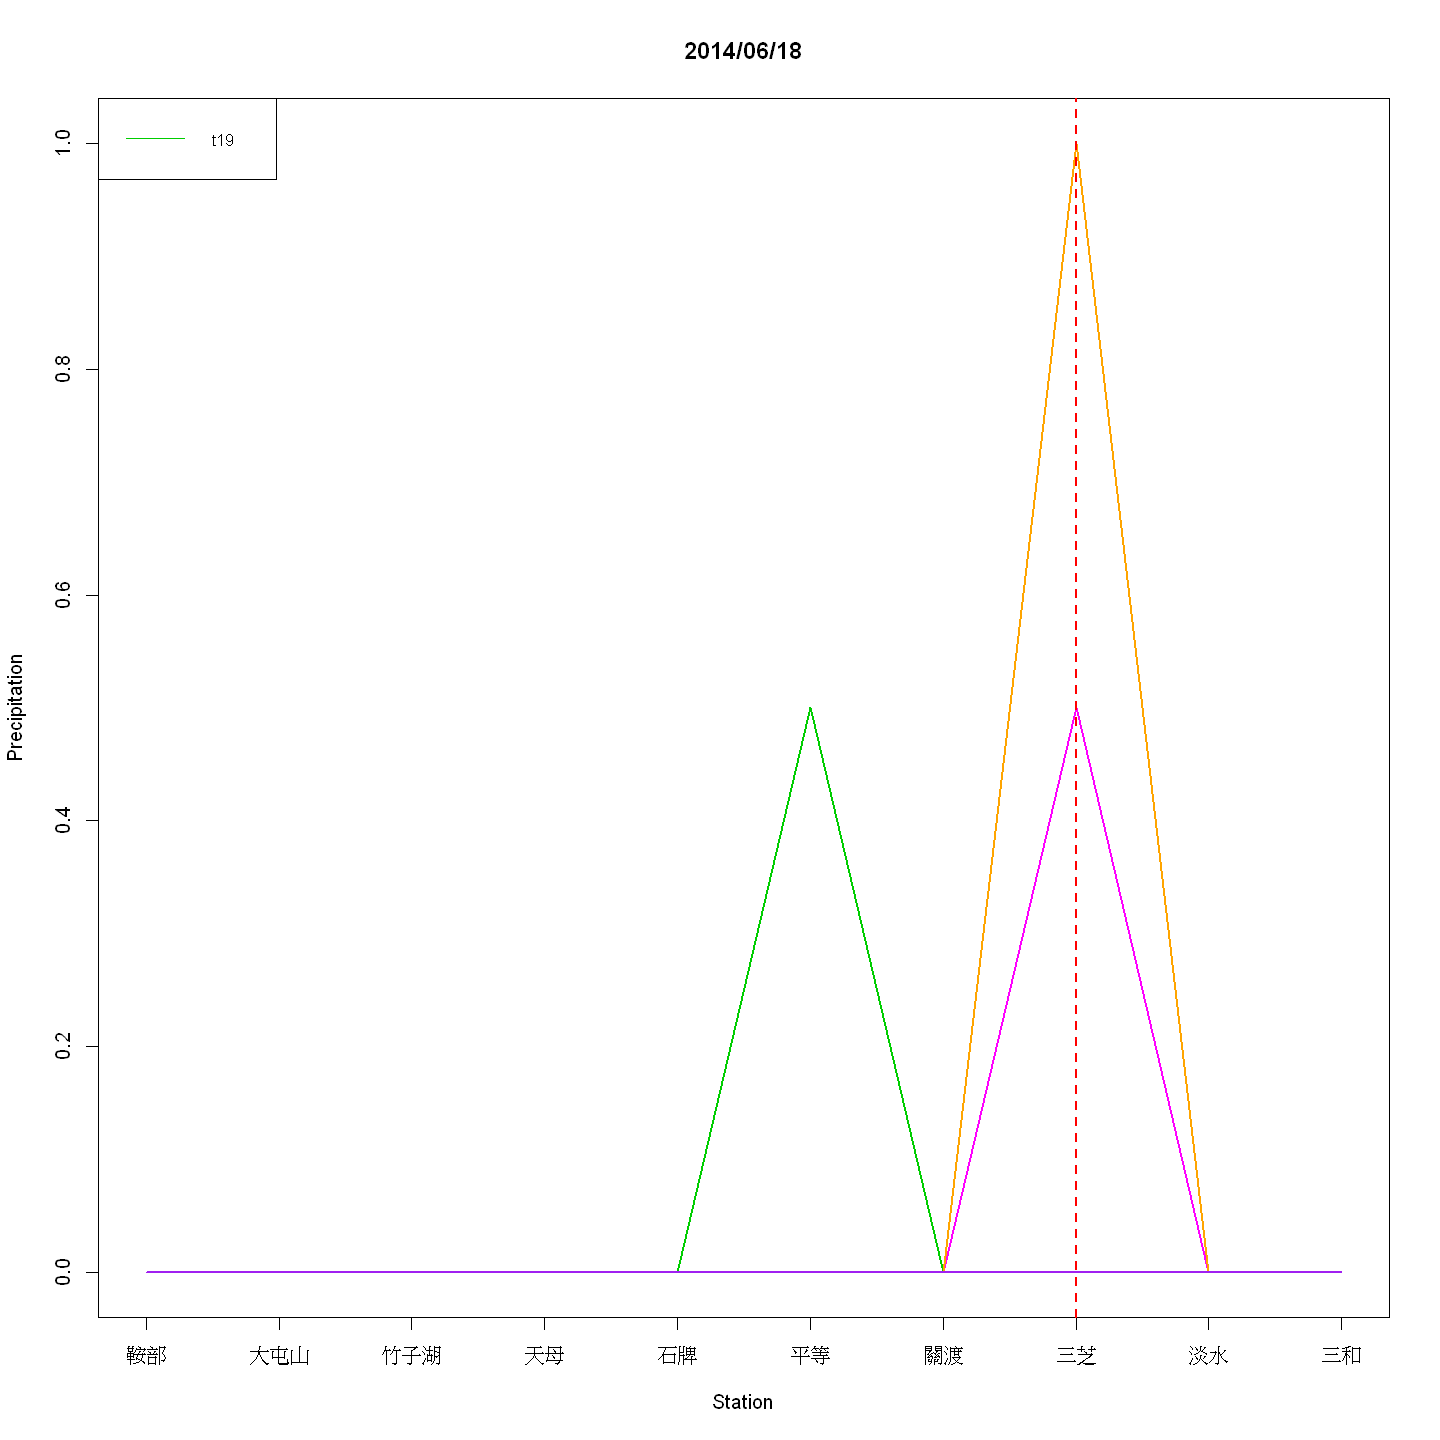

In [44]:
df.time <- t(df)
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = '2014/06/18',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('topleft', legend=c('t19'), lty=1, col=19, cex=0.8)

## 2016/05/30
距離約為2.7177

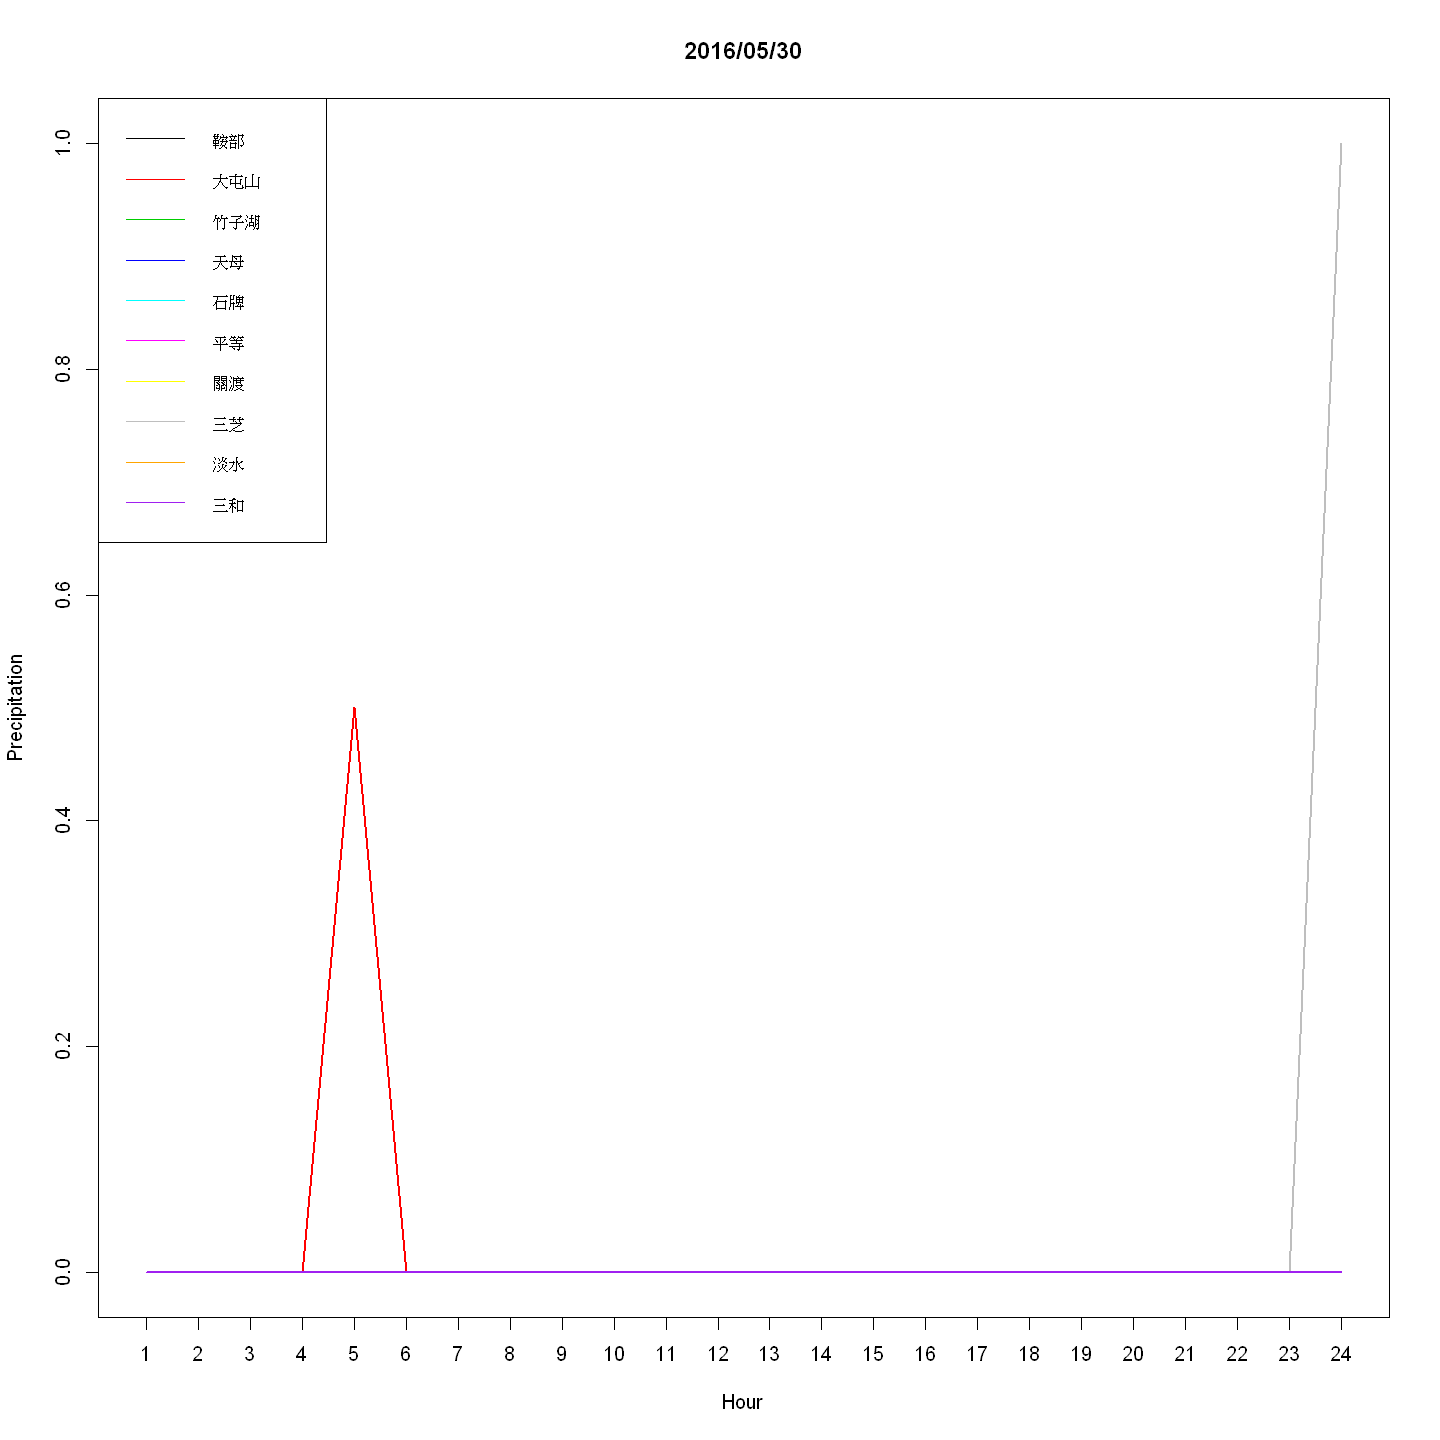

In [45]:
d0.ind <- which(df353.meiyu$Time %in% '2016/05/30 01')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, Nearest.ind]
df[is.na(df)] <- 0
df.space <- df

# Overplotted
plot.zoo(df.space, 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = '2016/05/30',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:24, labels = seq(1,24,1))
legend('topleft', legend=st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.8)

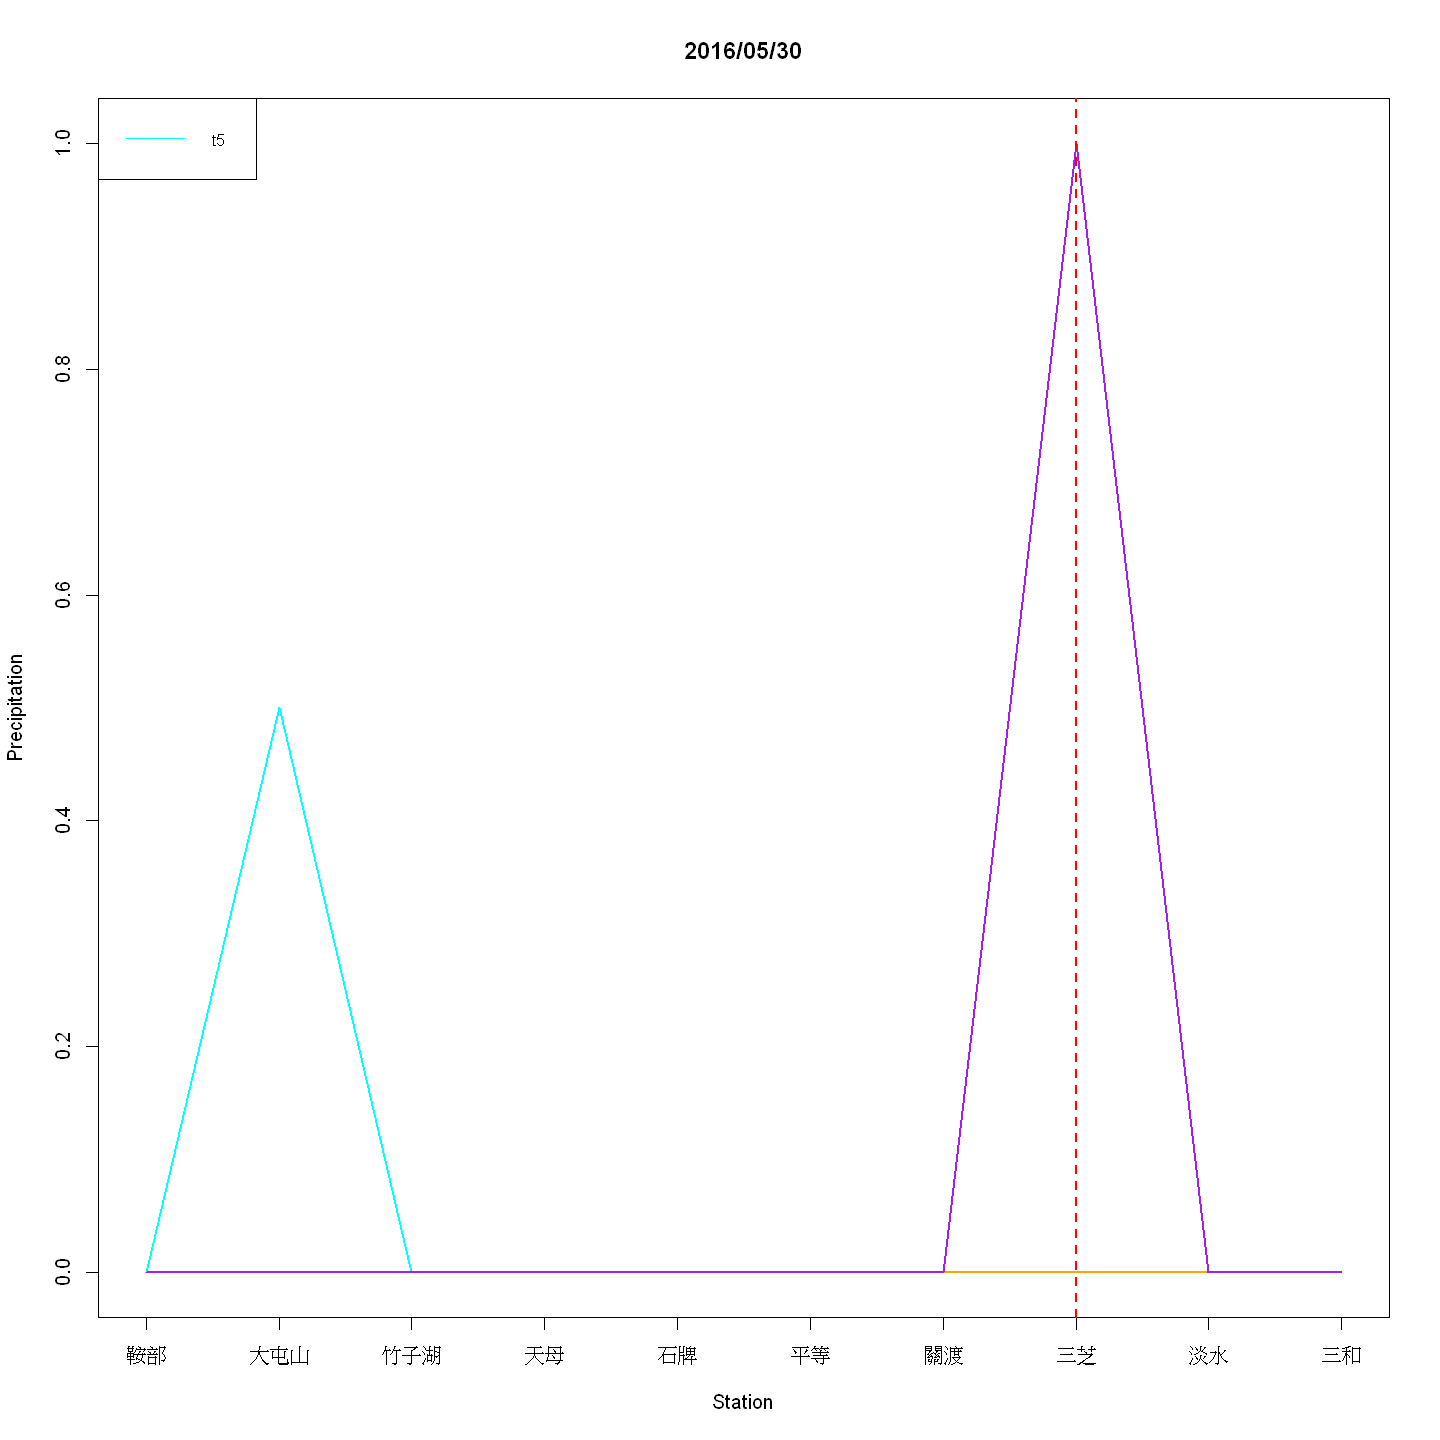

In [46]:
df.time <- t(df)
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = '2016/05/30',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('topleft', legend=c('t5'), lty=1, col=5, cex=0.8)

## 2017/05/14
距離約為4.2895

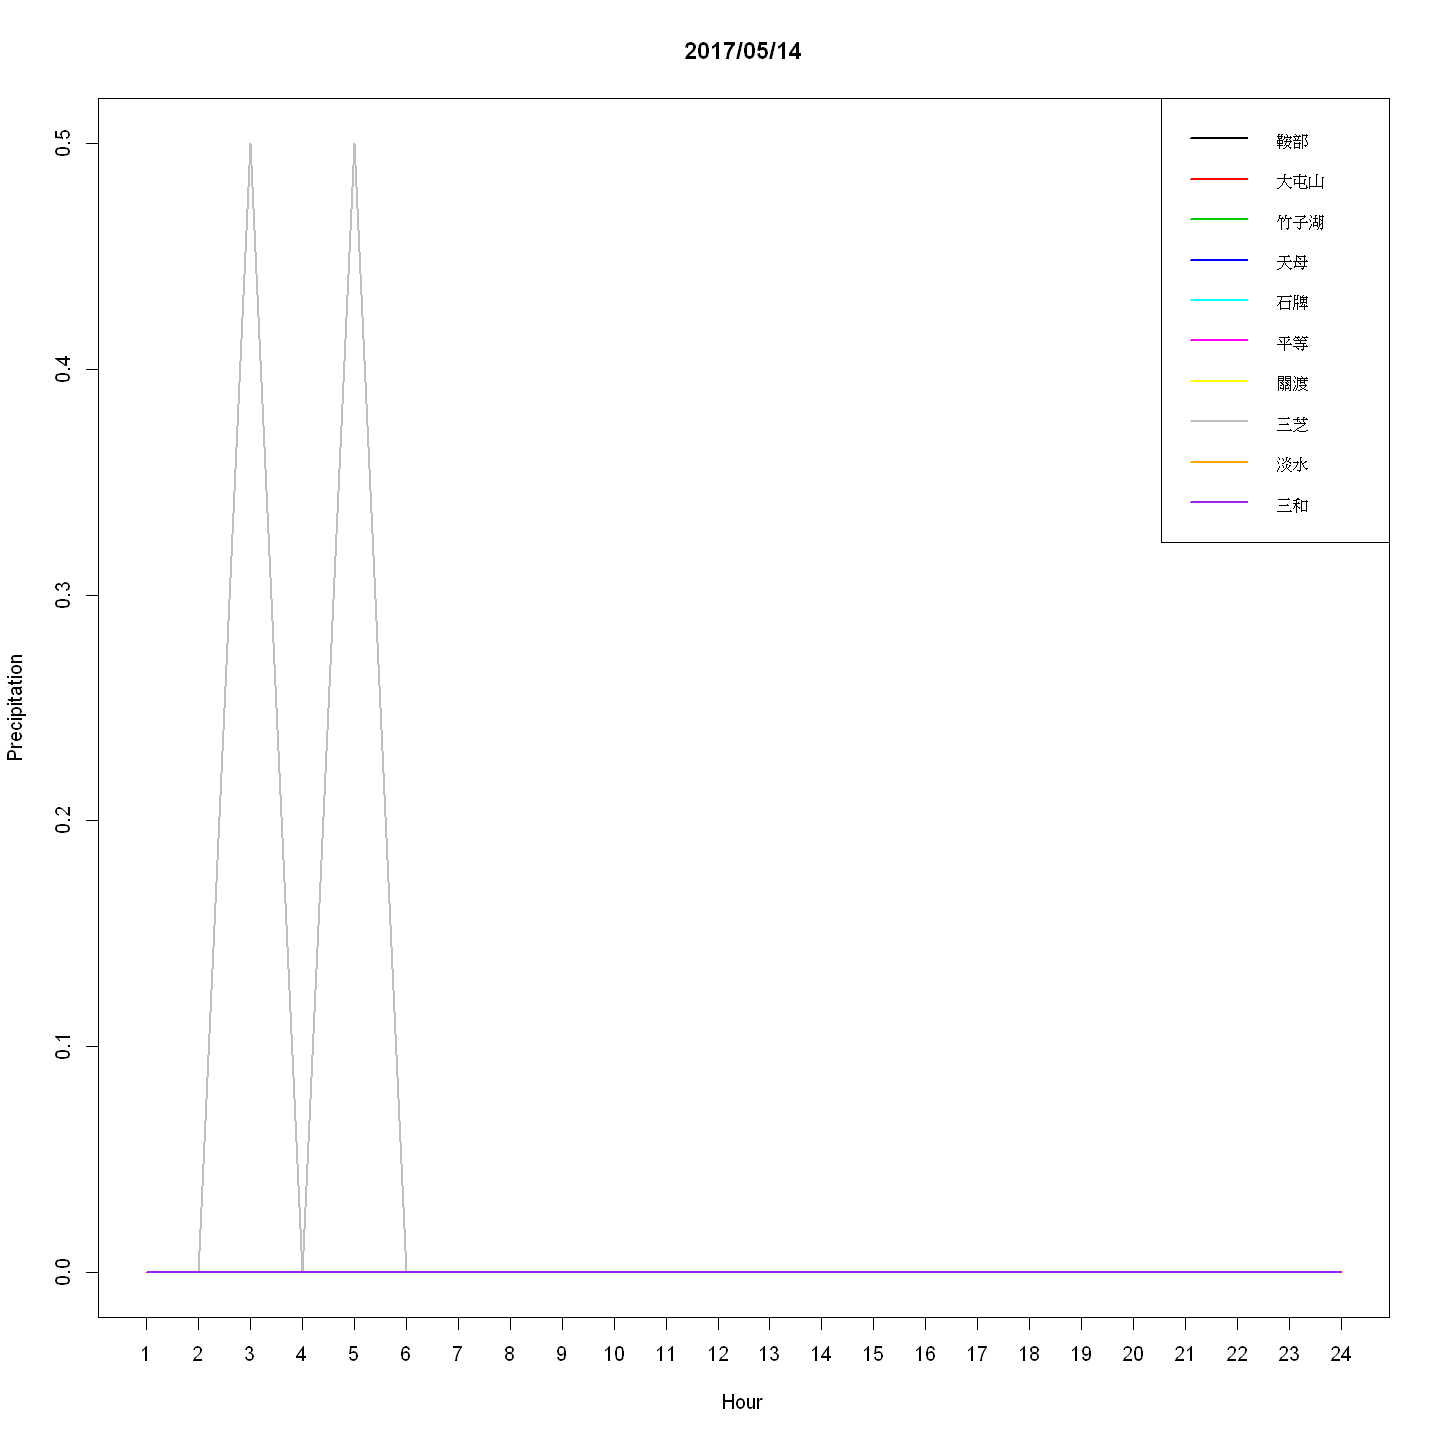

In [64]:
d0.ind <- which(df353.meiyu$Time %in% '2017/05/14 00')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, Nearest.ind]
df[is.na(df)] <- 0
df.space <- df

# Overplotted
plot.zoo(df.space, 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = '2017/05/14',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:24, labels = seq(1,24,1))
legend('topright', legend=st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.8, lwd = 2)

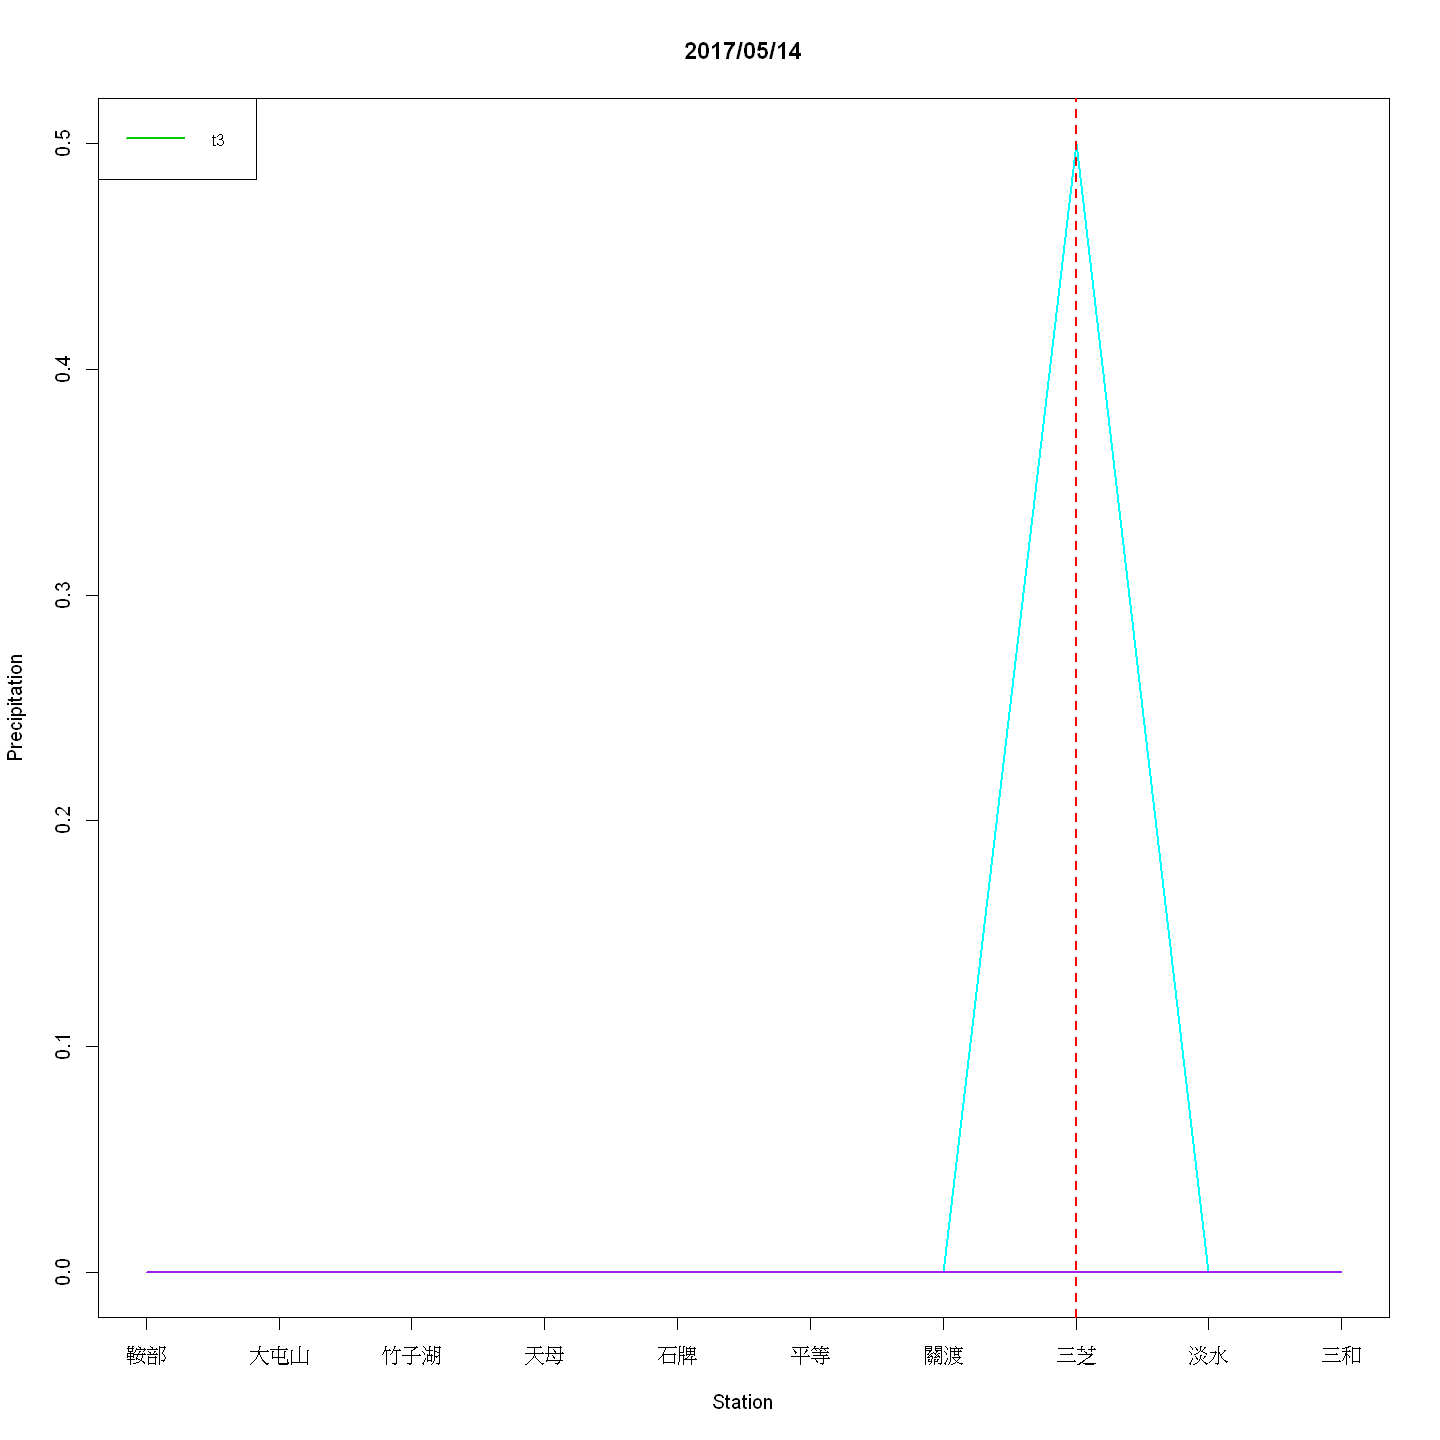

In [65]:
df.time <- t(df)
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = '2017/05/14',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('topleft', legend=c('t3'), lty=1, col=3, cex=0.8, lwd = 2) # 3rd and 5th hour overlap

## 2017/06/02
距離約為7.2675

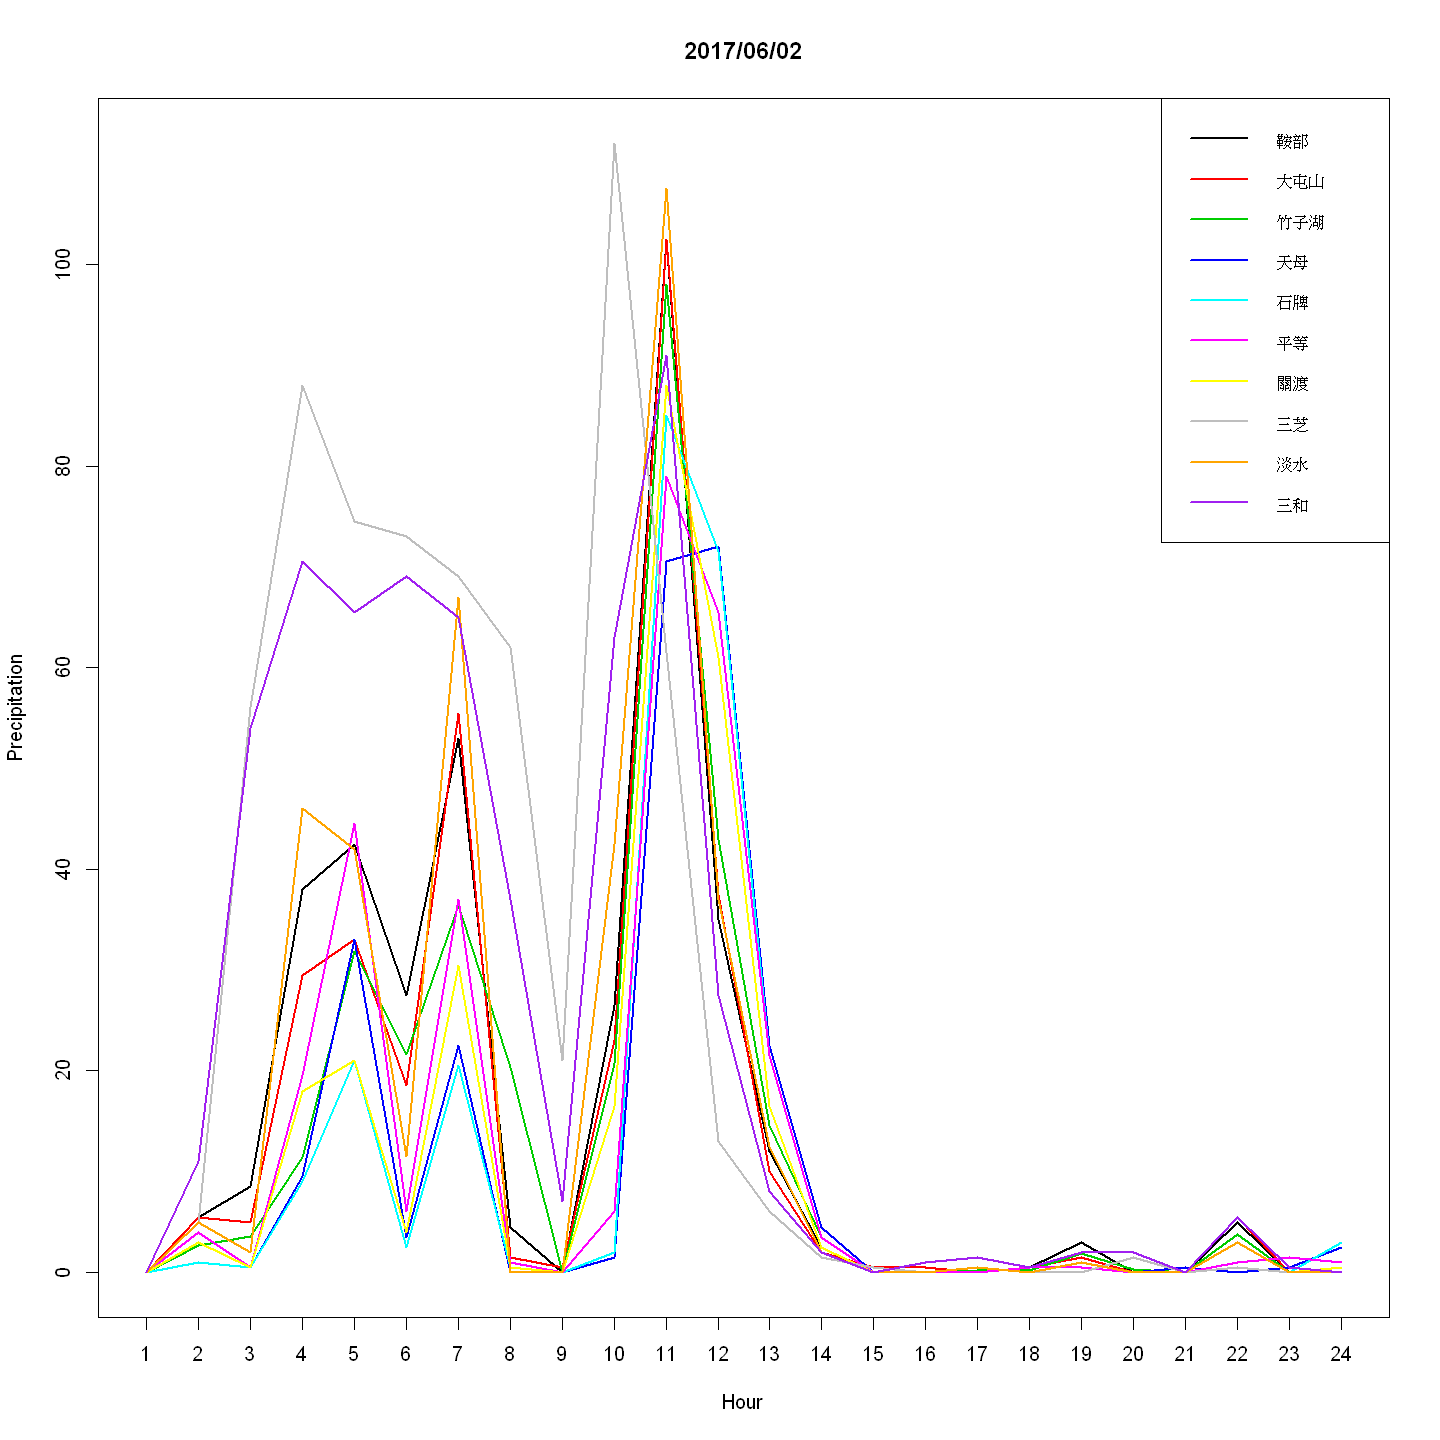

In [55]:
d0.ind <- which(df353.meiyu$Time %in% '2017/06/02 00')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, Nearest.ind]
df[is.na(df)] <- 0
df.space <- df

# Overplotted
plot.zoo(df.space, 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = '2017/06/02',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:24, labels = seq(1,24,1))
legend('topright', legend=st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.8, lwd = 2)

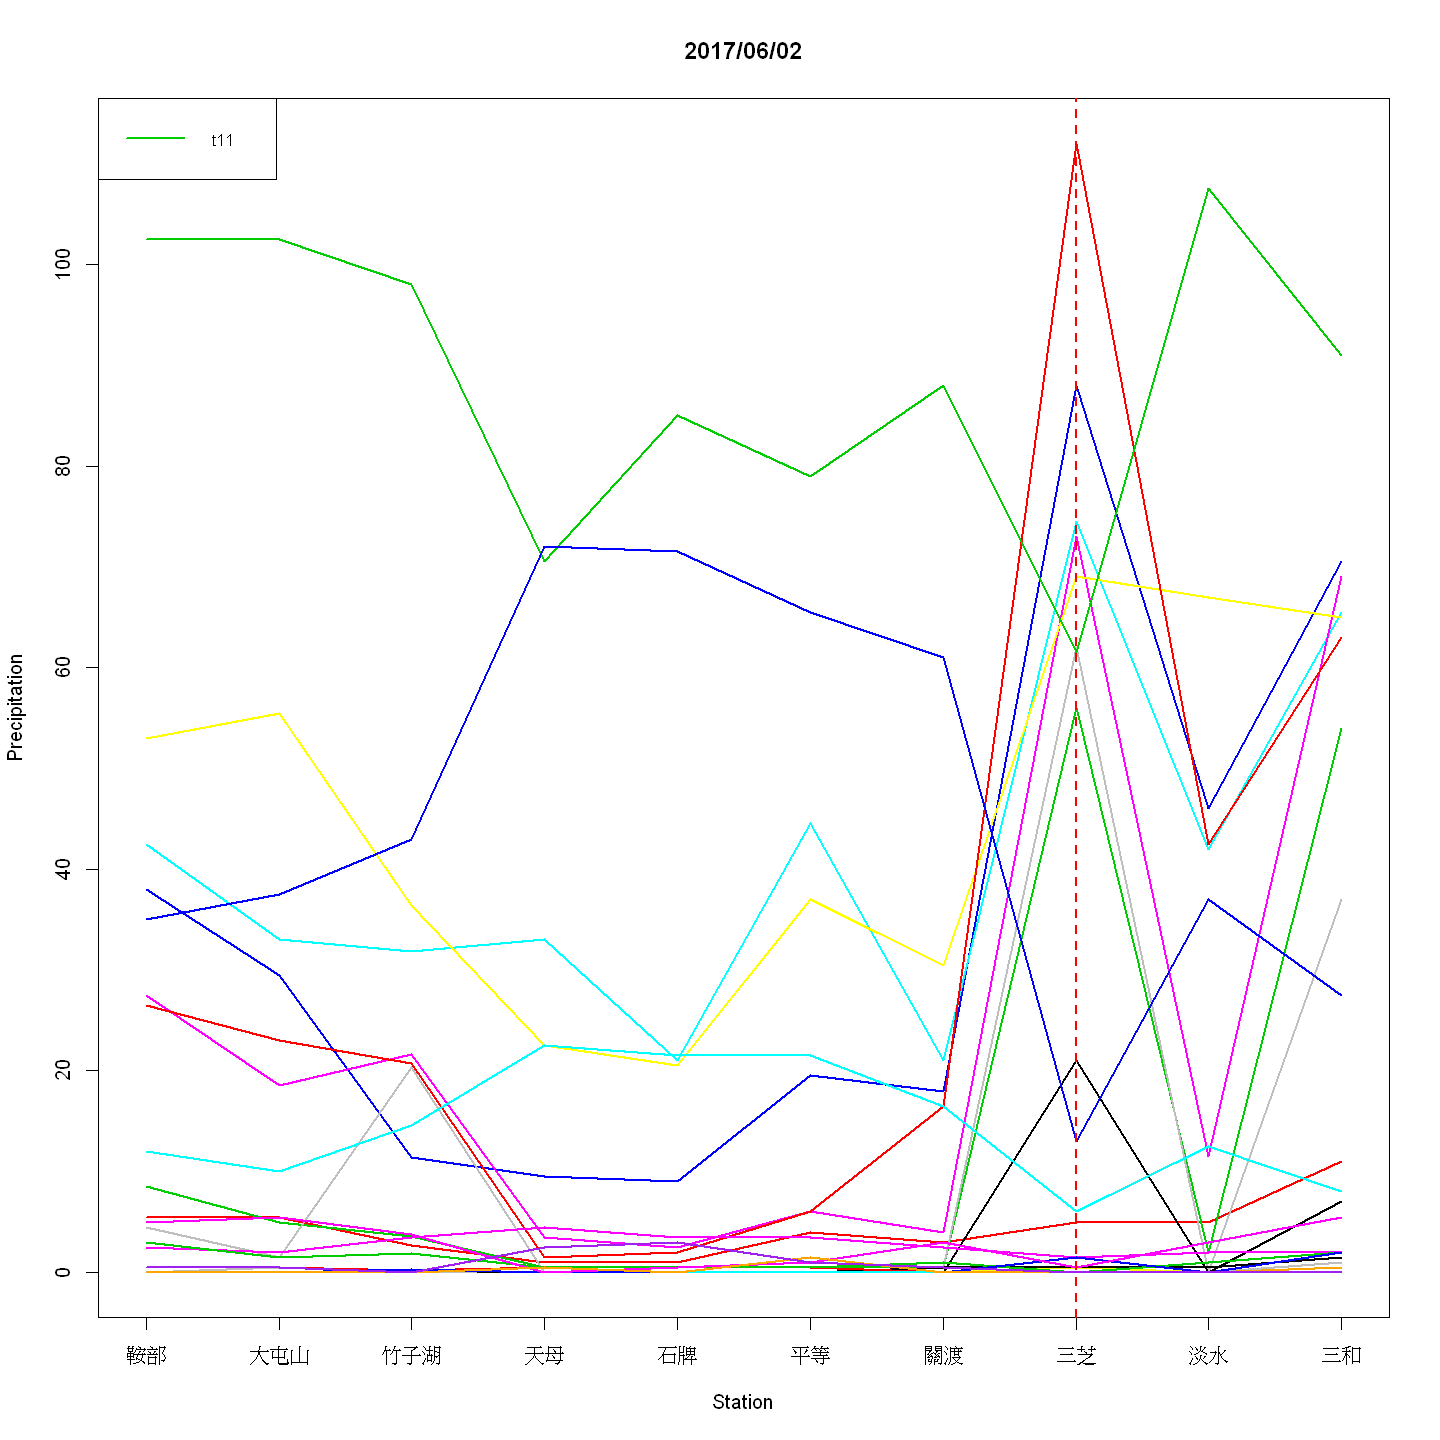

In [56]:
df.time <- t(df)
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = '2017/06/02',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('topleft', legend=c('t11'), lty=1, col=11, cex=0.8, lwd = 2)

## 2018/05/07
距離約為2.7177

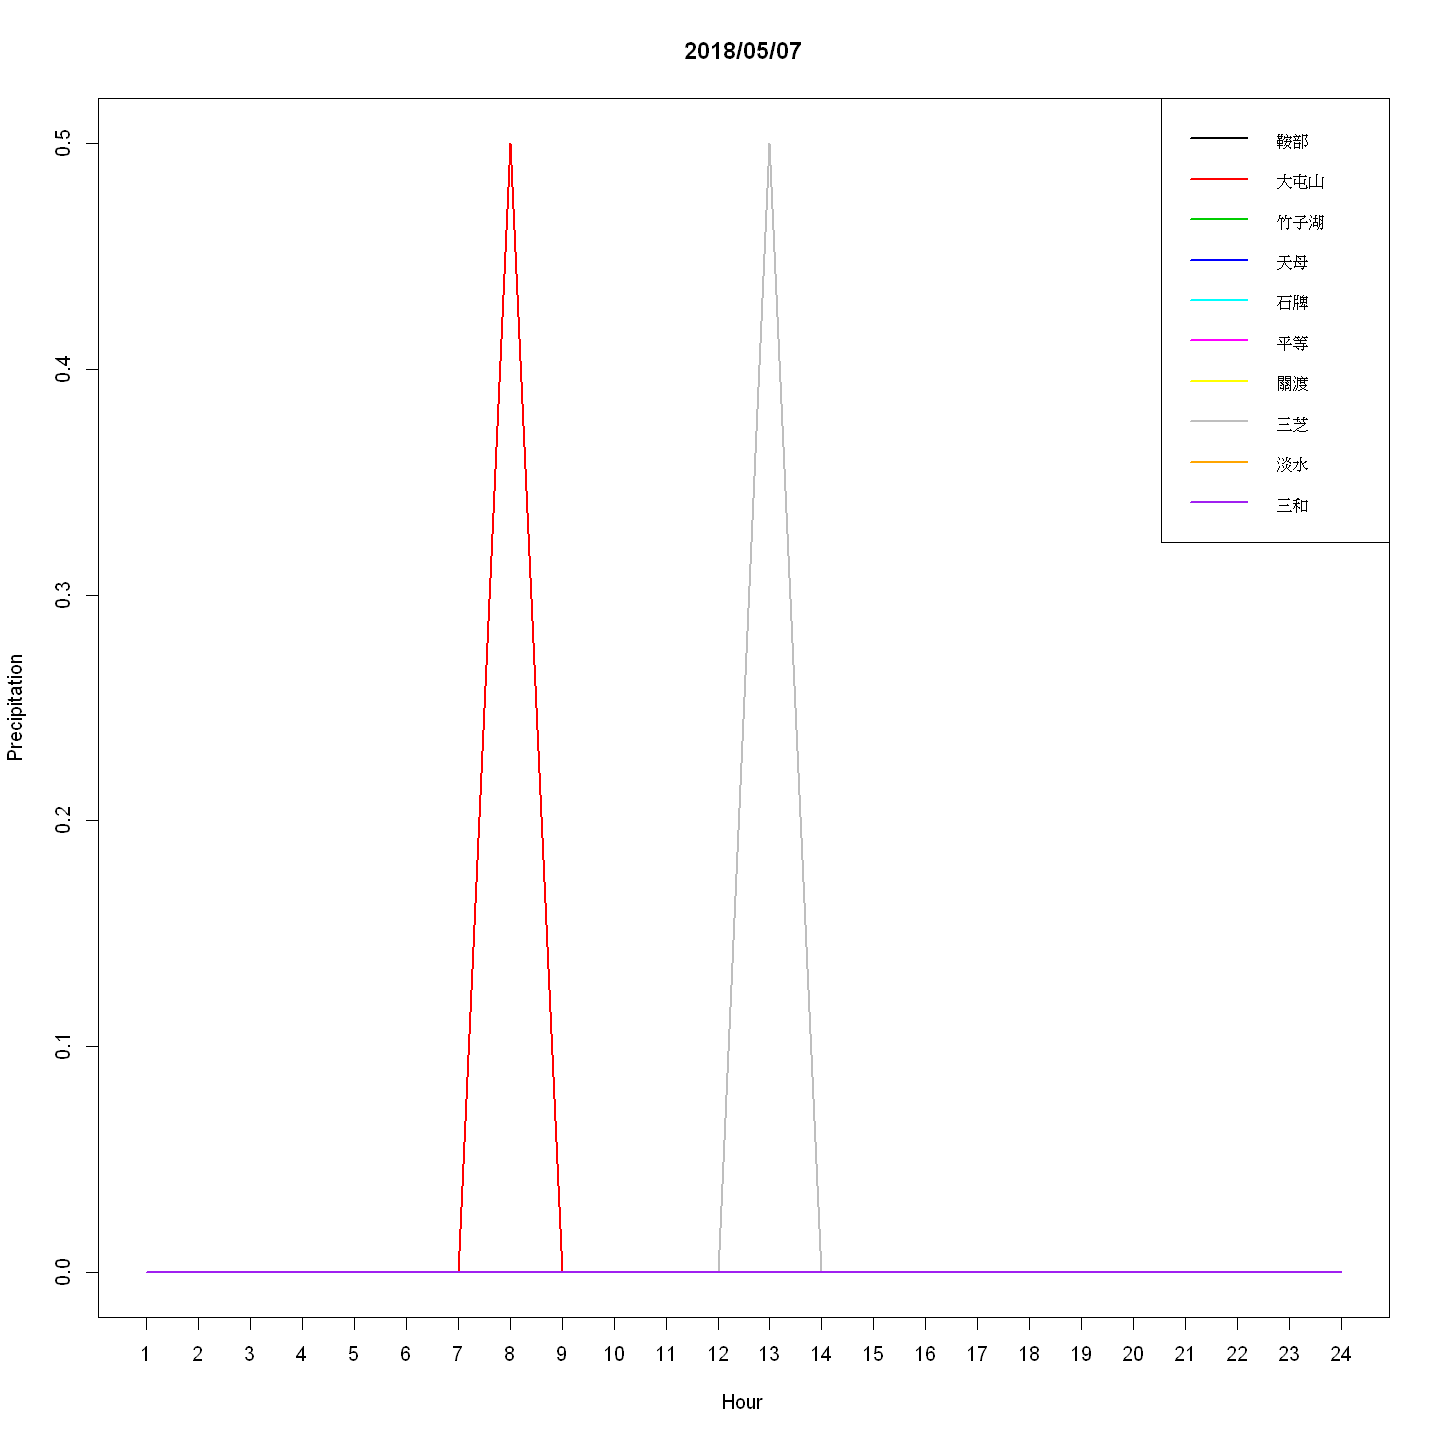

In [53]:
d0.ind <- which(df353.meiyu$Time %in% '2018/05/07 00')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, Nearest.ind]
df[is.na(df)] <- 0
df.space <- df

# Overplotted
plot.zoo(df.space, 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = '2018/05/07',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:24, labels = seq(1,24,1))
legend('topright', legend=st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.8, lwd = 2)

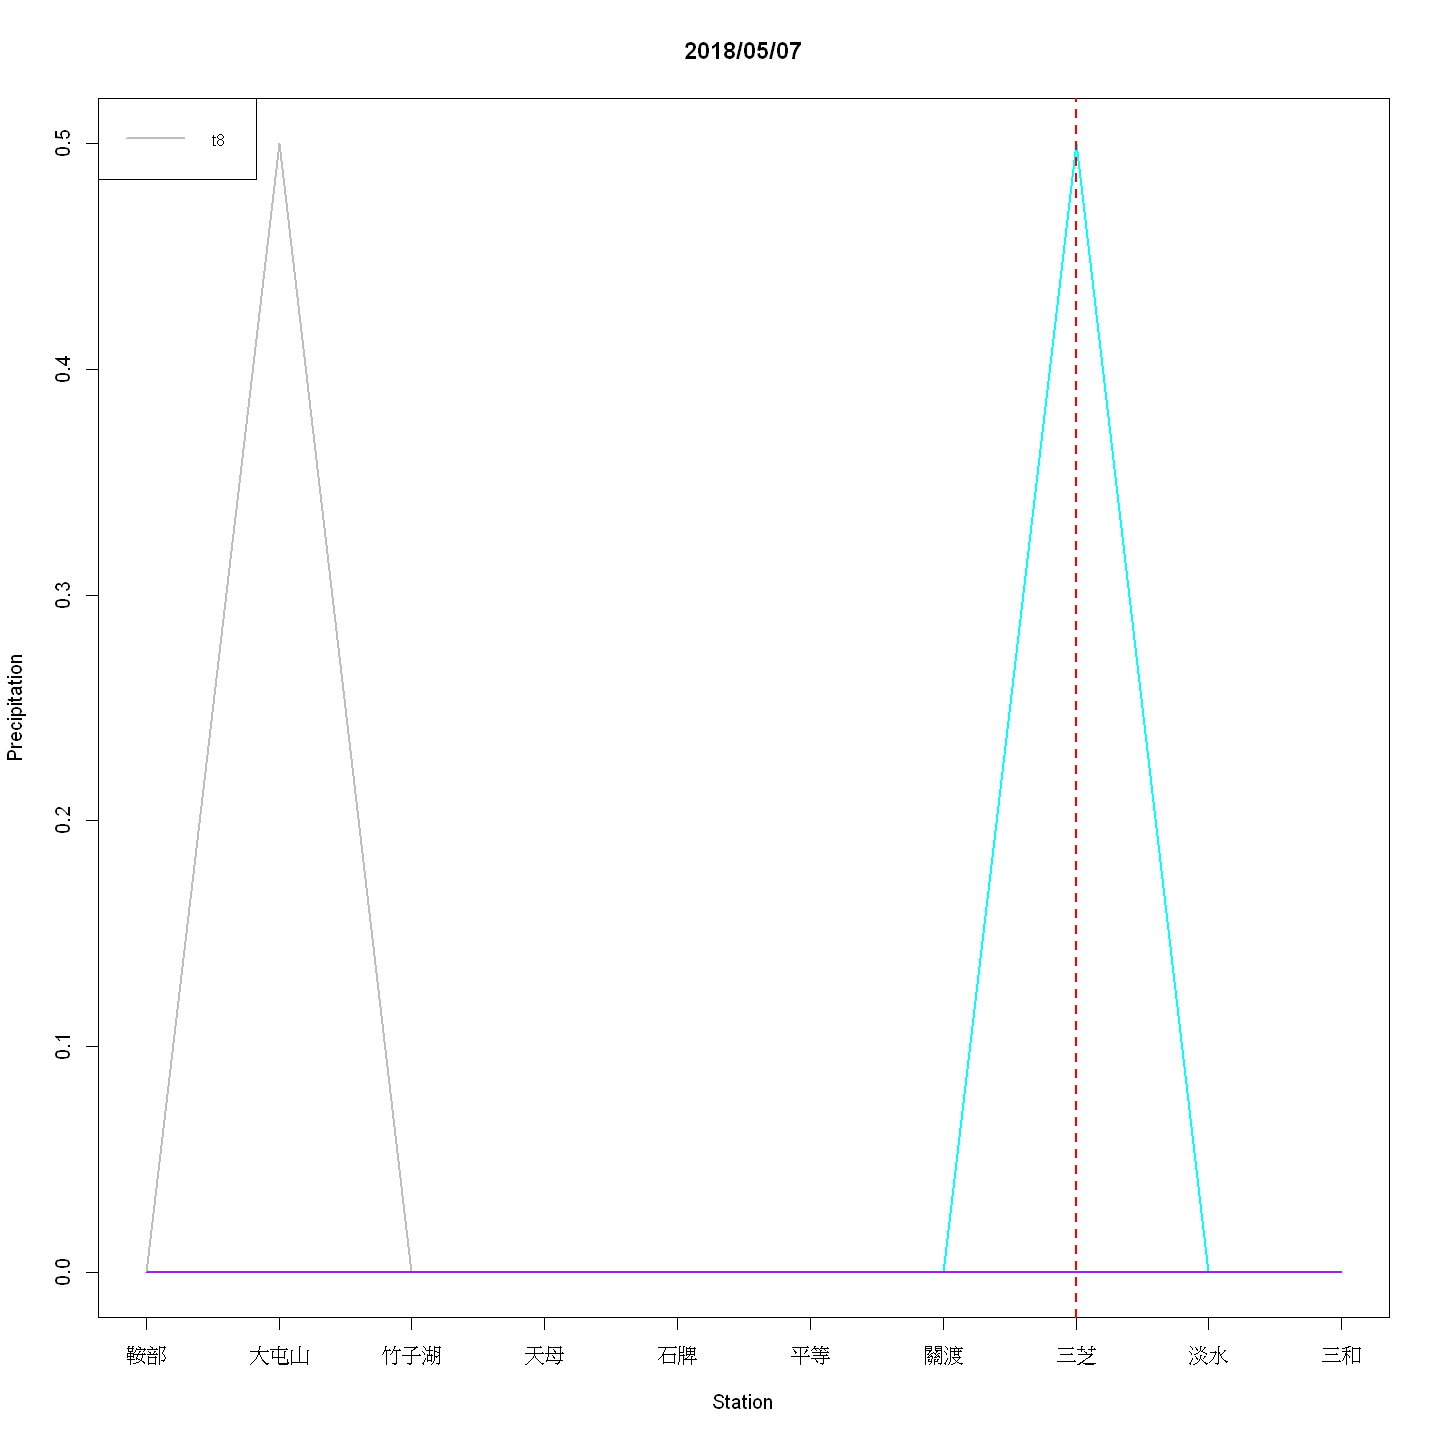

In [54]:
df.time <- t(df)
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = '2018/05/07',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('topleft', legend=c('t8'), lty=1, col=8, cex=0.8, lwd = 2)